## Chapter 11: Principles of Feature Learning

# 11.2 The bias-variance trade-off, validation error, and cross-validation

We have just seen how any number of *universal approximators* can be used to approximate *perfect data* as well as desired.  In order to do this all we need do increase the capacity of our model to a sufficient level (by adding enough units of a particular universal approximator) and tune their parameters via the minimization of an appropriate cost.  With real data this general concept does not change - so long as we use enough units of a particular universal approximator and tune their parameters properly we can approximate real *training data* as closely as we like.  However with *real* data increasing model capacity arbitrarily produces a seriously undesirable effect: after a certain point the model will provide a very poor representation for the data generating phenomenon, and hence will provide a poor predictor for future input.  Thus in practice we must take considerable care in both selecting proper amount of capacity for our model and tuning its parameters with real data.  As we will see in doing this model can range from being on the one hand too *inflexible* to on the other being too *flexible* - general problem referred to as the *bias-variance trade-off*.  To navigate this trade-off we will also learn about a new measurement tool - called *validation error*.

Note - here as in the previous Section - for simplicity here we largely focus our discussion on regression and two-class classification examples, however the fruits of this entire discussion are widely applicable to other problem types including multi-class classification and unsupervised learning problems like nonlinear autoencoder.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels

# plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# generic tools
import math

# This is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.2.1  Universal approximators and real data

In the previous Section we saw how a nonlinear model built from units of universal approximator can tightly represent any *perfect dataset* if we increase its capacity sufficiently - that is provided we choose enough units - and tune its parameters by minimizing an appropriate cost function.  Remember - in the jargon of machine learning the amount of nonlinearity, or nonlinear potential, a model has is commonly referred to as its *capacity*.  Moreover *increasing the capacity of our model* (by e.g., adding *more* units) always improves our model's ability to represent our perfect training data.

The same general principle holds with *real data* as well - that is data that is *finite* and *noisy*: the more units / the better we tune the parameters of a model built from universal approximators the better our approximation *to the data* becomes.   However this fact has a very serious undesirable consequence with real data: after a certain point we can fit a *training dataset too well* producing a model that fails to accurately represent the nature of the phenomenon generating our data.  This sort of phenomenon is a problem regardless of the sort of universal approximator we use - whether it be a kernel, neural network, or tree-based catalog of functions - and regardless of the machine learning problem we face (regression / classification as well as unsupervised learning problems).  

Below we explore this problem using two simple examples - a regression and two-class classification dataset.  The problems we encounter with these two simple examples mirror those we face in general when employing universal approximator-based models.

 #### <span style="color:#a50e3e;">Example 1. </span>   Universal approximation of real regression and classification data

In this example we illustrate the problem of overfitting using a real regression dataset that is based on the near-perfect sinusoidal data presented in Example 3 of the previous Section.  Here to simulate a real version of this dataset we randomly select $P = 21$ of these points and add a small amount of random noise to each's output.

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/sin_to_data.png' width="90%" height="25%" alt=""/>
</td>
</tr>

<figure>
 <figcaption> <strong>Figure 1:</strong> <em> 
(left panel) The original near-perfect sinusoid dataset from Example 3 of the prior Section.  (right panel) A real dataset formed from a noisy subset of these points.
</em>
</figcaption>
</figure>


In the panels below we illustrate the fully tuned nonlinear fit of a model employing $1$ through $20$ polynomial units (left panel), single layer tanh neural network (middle panel), and stump units (right panel) to this data.  Notice how - with each of the universal approximator - all three models *underfit* the data when using $B = 1$ unit, and each improves (in terms of how well it represents the data) as we increase $B$.   At around $B = 3$ or $B = 4$ units with the polynomial and neural network approximators, and around $B = 8$ units with stumps each model approximates the desired sinusoid quite well.  However after this point
each model starts to look rather wild and very much unlike the sinusoidal phenomenon that originally generated the data.  This is especially visible in the polynomial and neural network cases, where by the time we reach $B = 20$ units both models are extremely oscilatory.  Such *overfitting* models - while representing the training data well - will clearly make for poor predictors of future data generated by the same process.


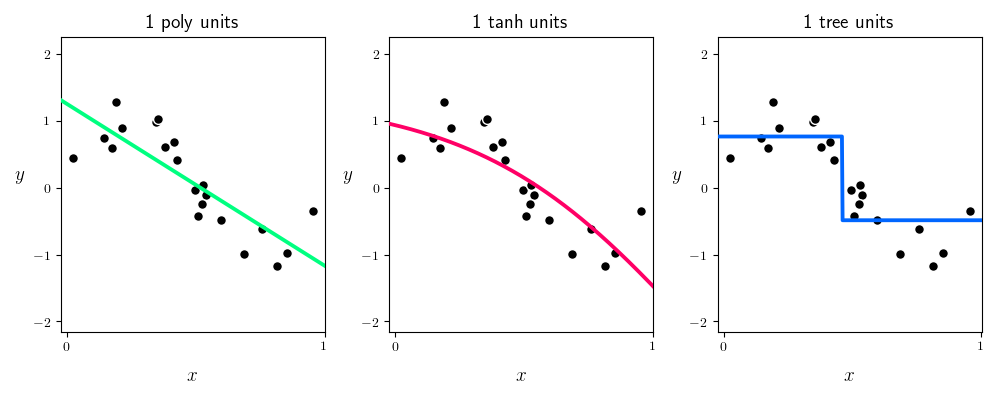
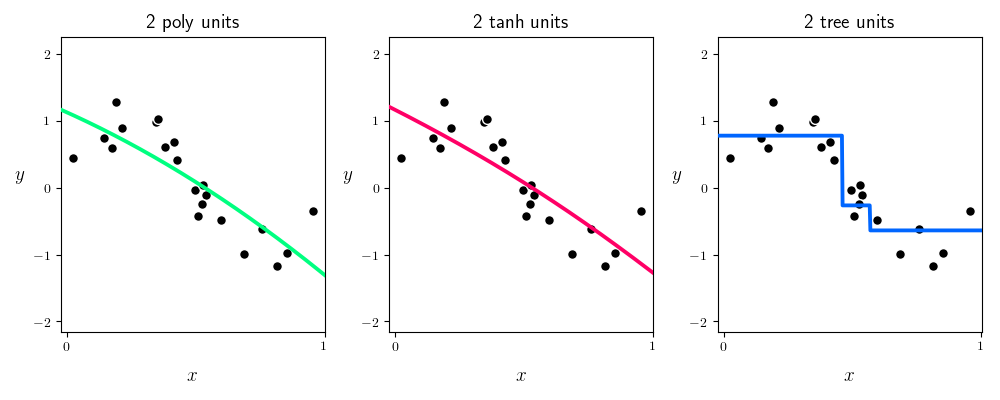
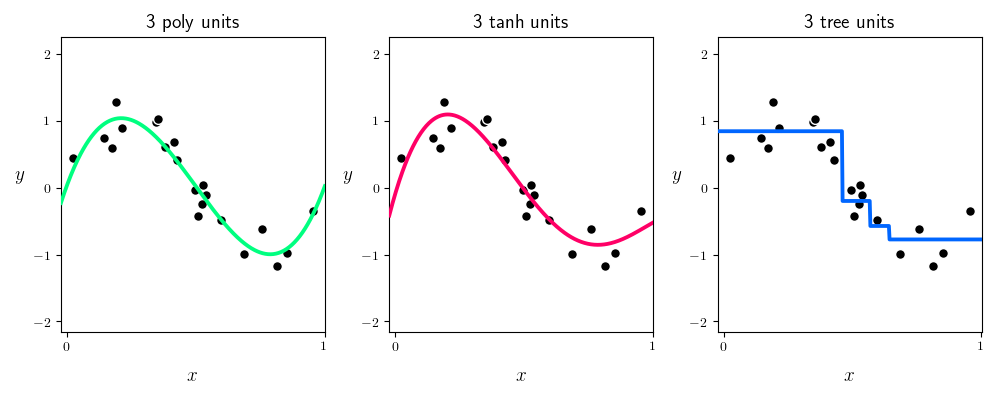
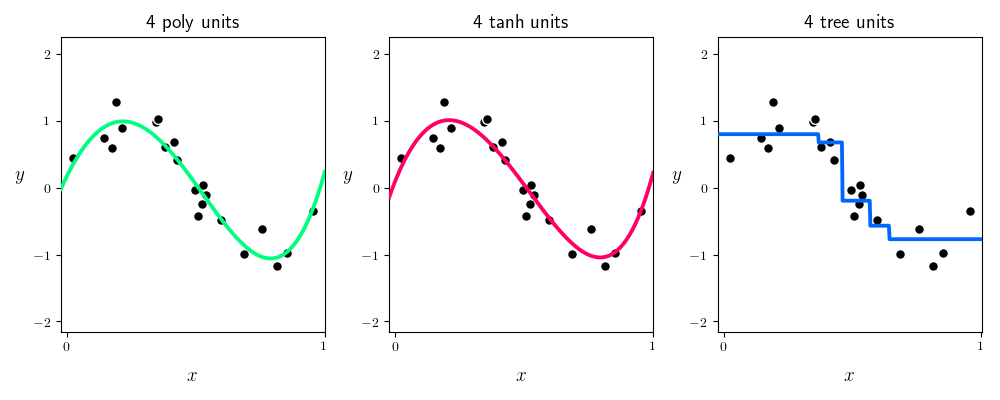
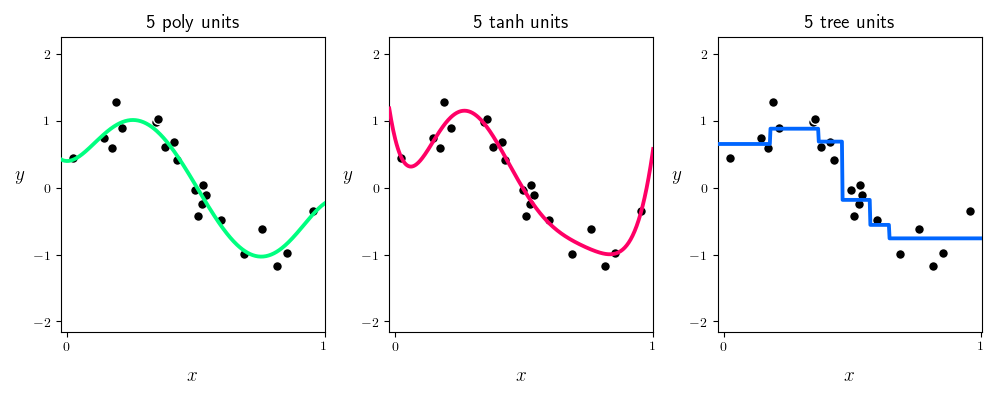
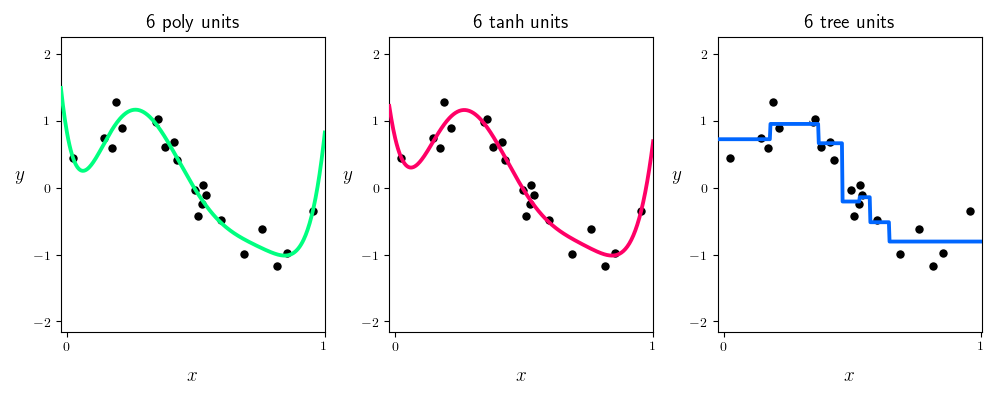
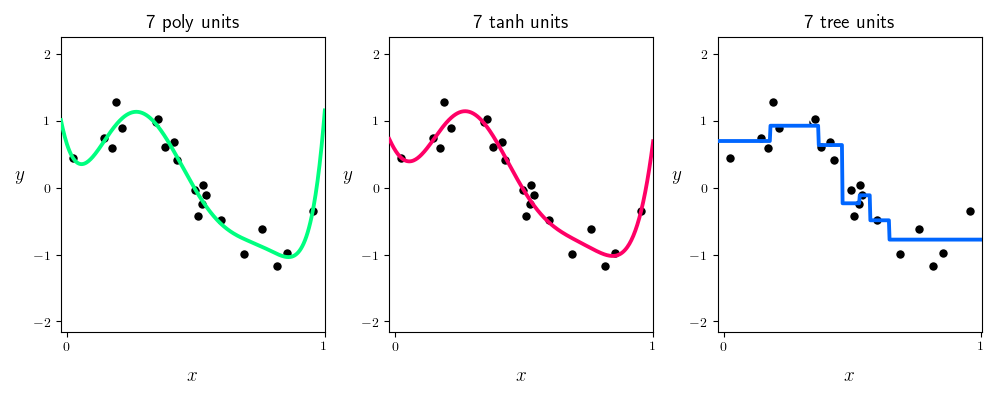
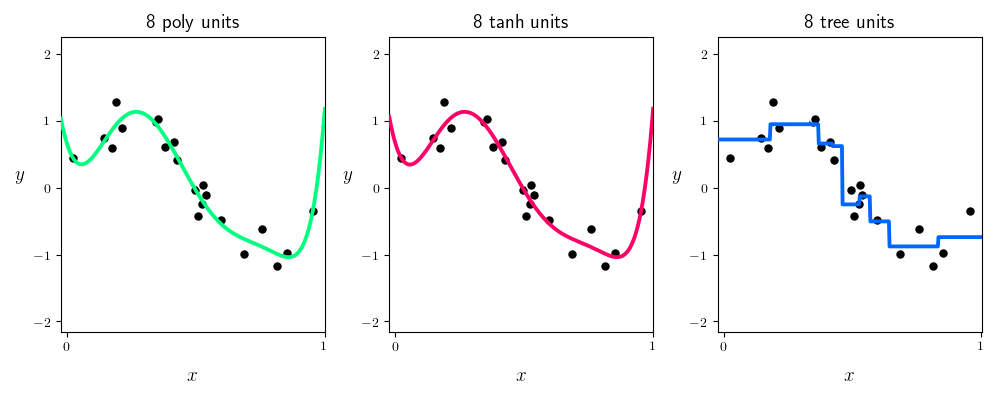
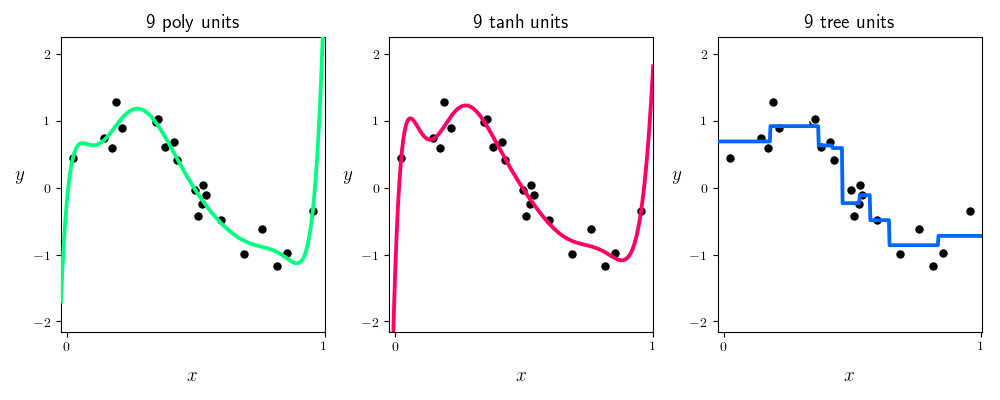
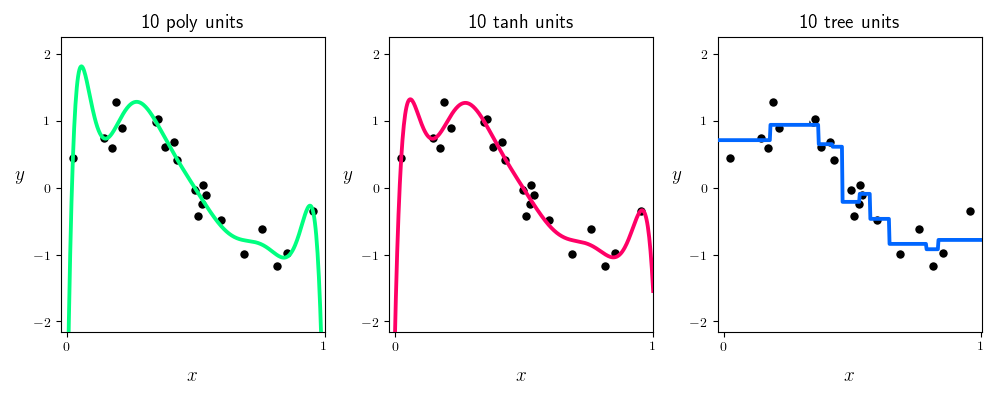
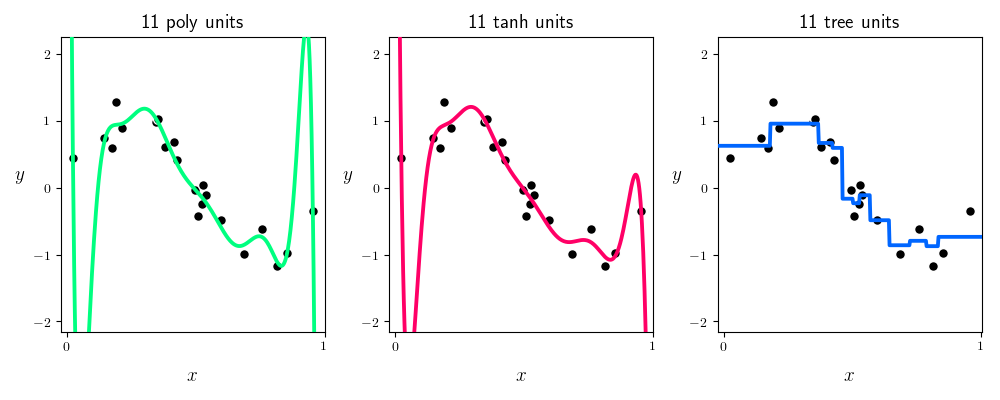
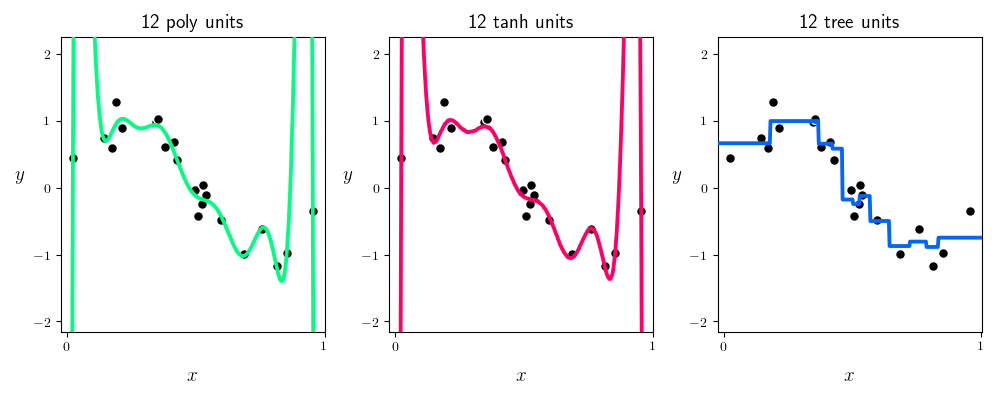
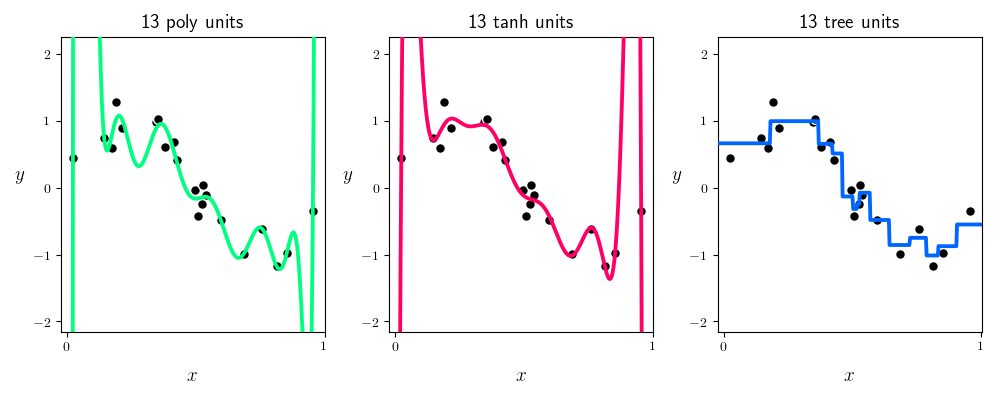
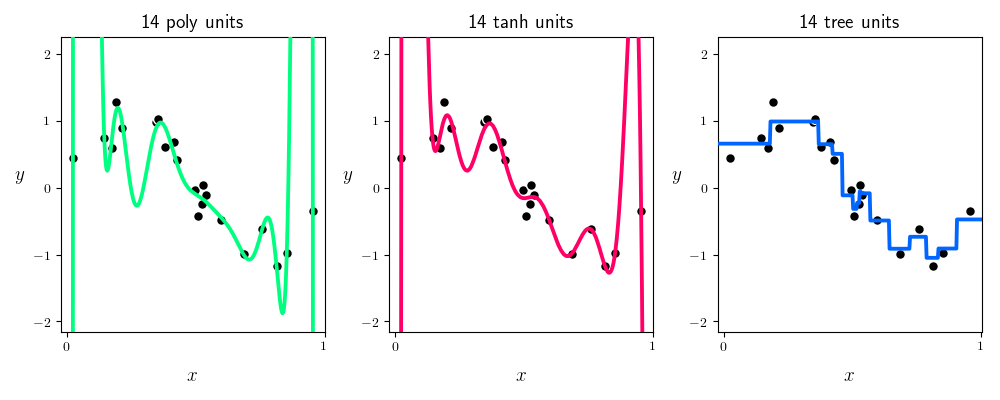
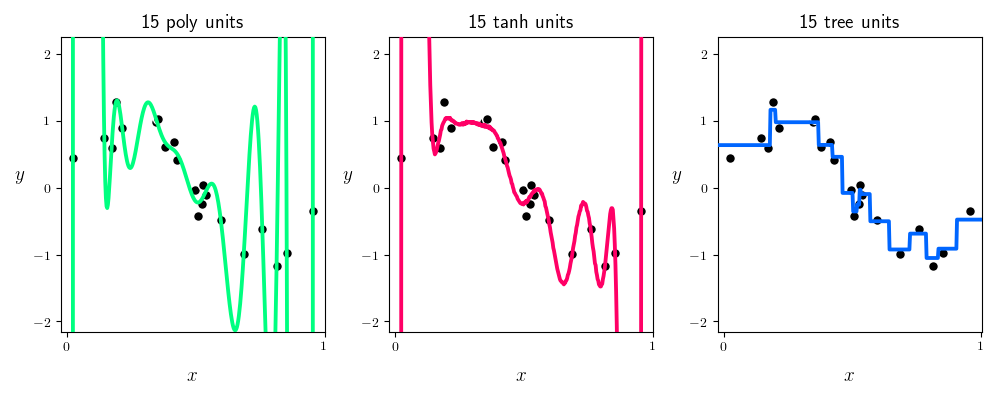
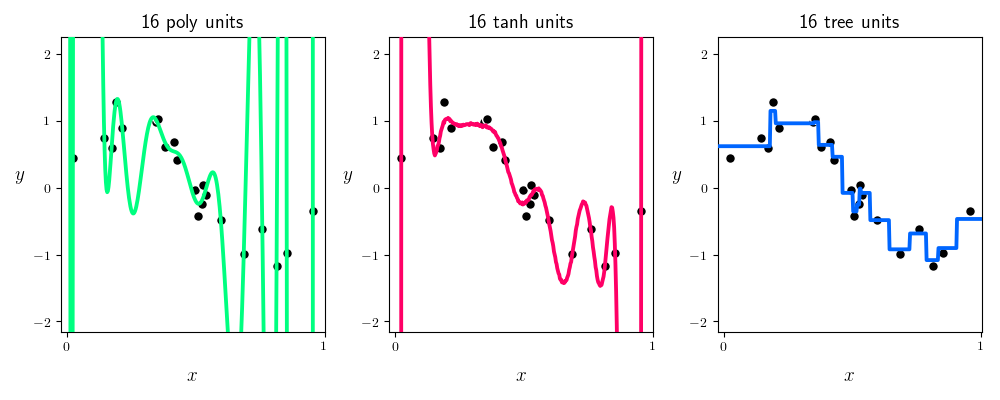
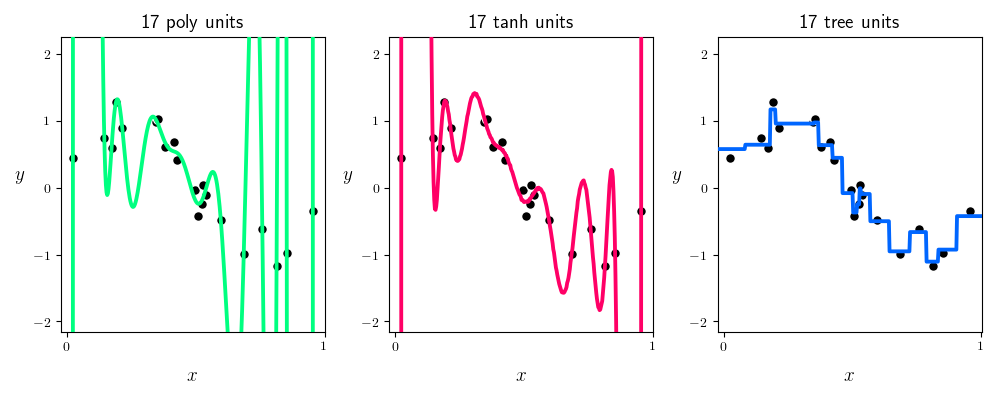
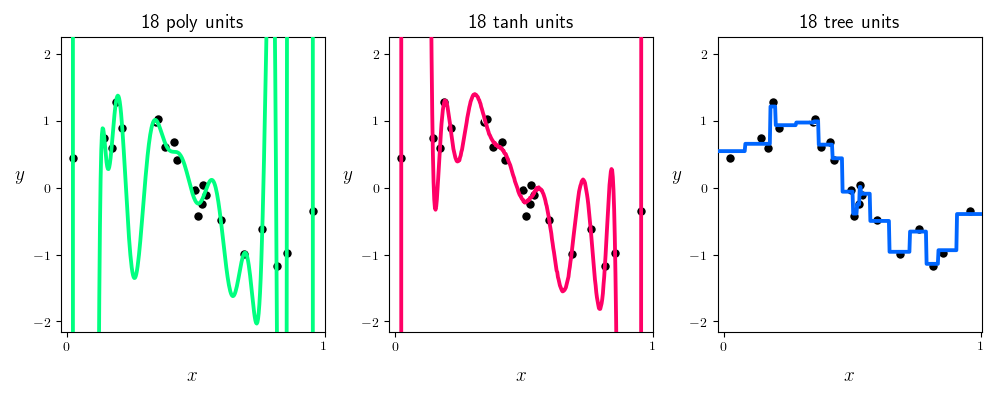
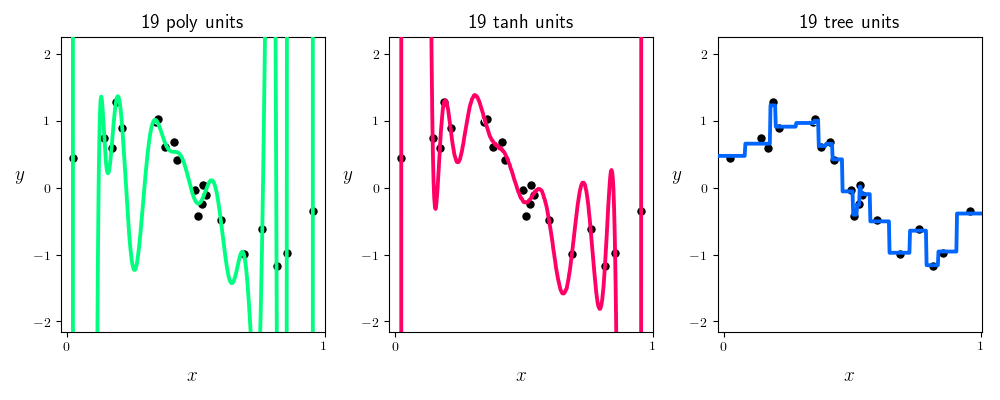
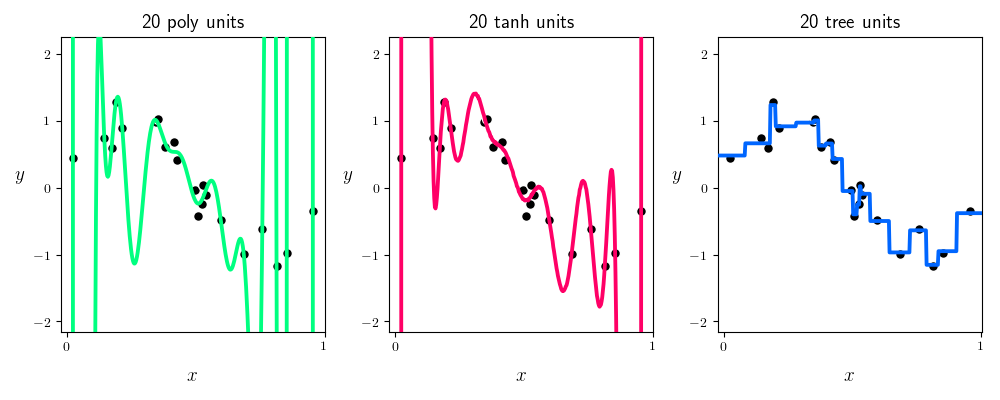

In [12]:
## This code cell will not be shown in the HTML version of this notebook
# run comparison demo for regression using all three main catalogs of universal approximators
demo1 = nonlib.regression_basis_comparison_2d.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo1.load_data(csvname)
demo1.brows_fits(num_elements = [v for v in range(1,21,1)],scatter = 'on')

In the figure below we plot several of the polynomial-based models shown above (left panel), along with the corresponding Least Squares cost value each attains on the training set (right panel) - i.e., the model's *training error*.  As you can see adding more polynomial units always *decreases* the cost function value (just as in the 'perfect' data case) - fitting the training data better and better as units are added to the model.  However the resulting fit - after a certain point - actually gets *worse in terms of how it represents the general regression phenomenon*.  Remember that a cost function's value computed over training data tells us how well our model fits *training data only*, but it does *not* tell us when our model *overfits training data*.


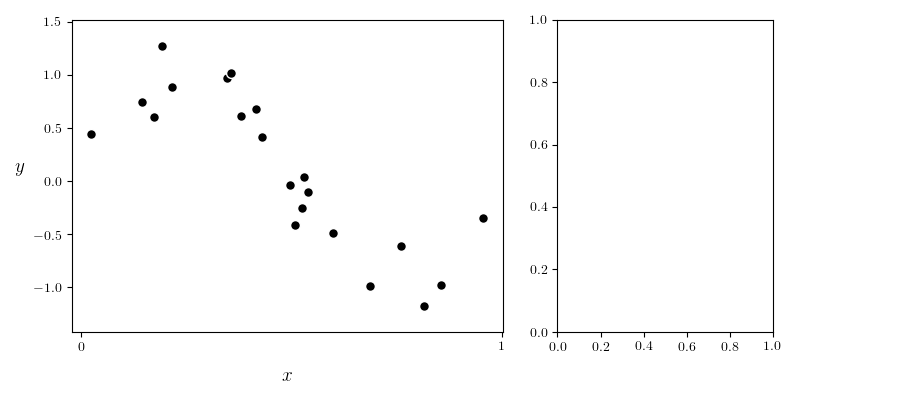
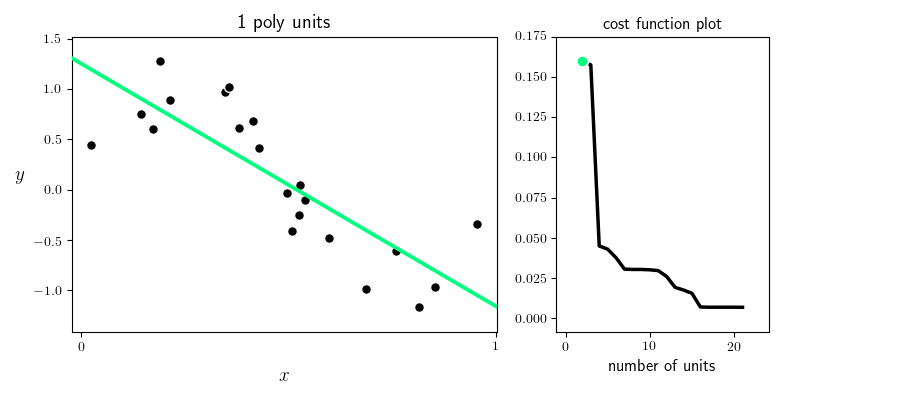
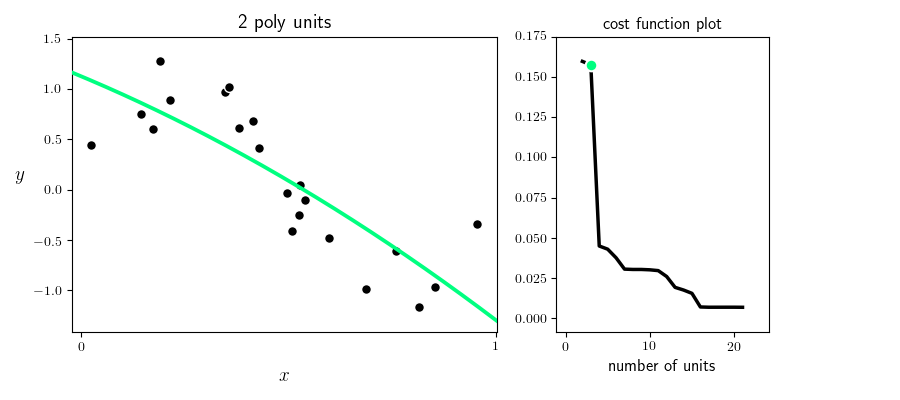
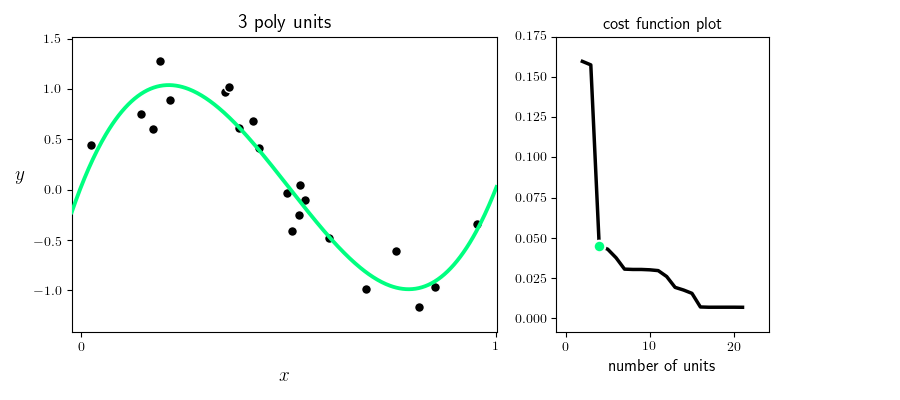
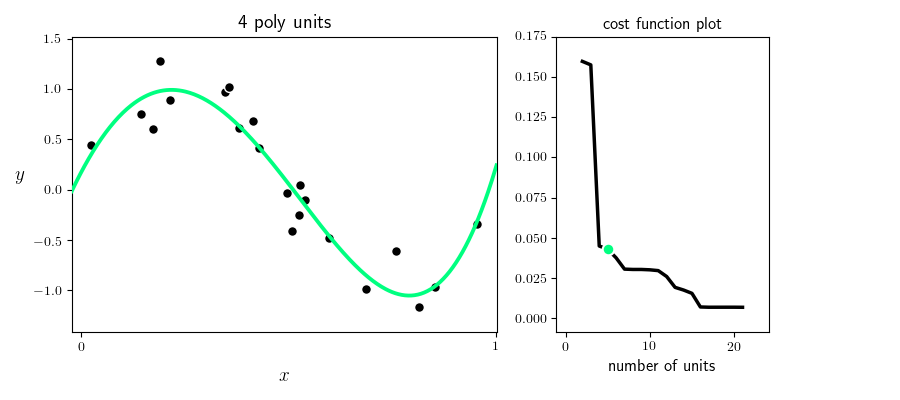
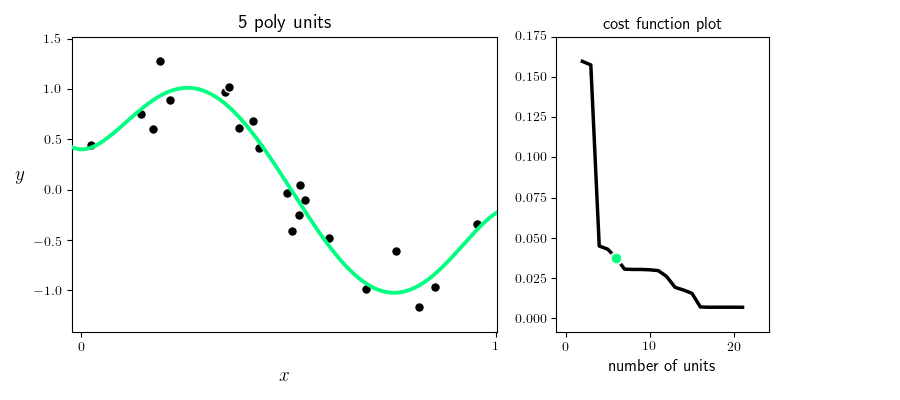
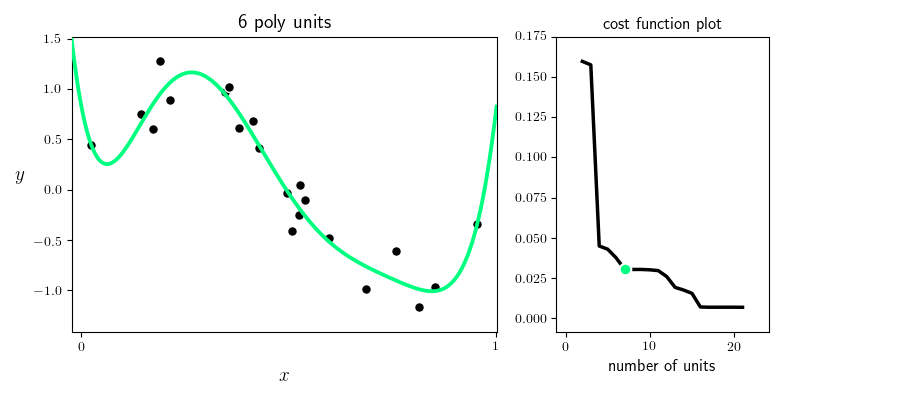
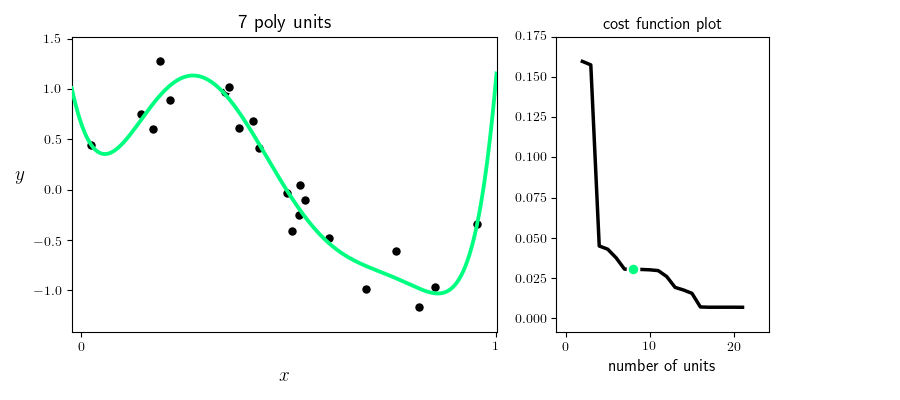
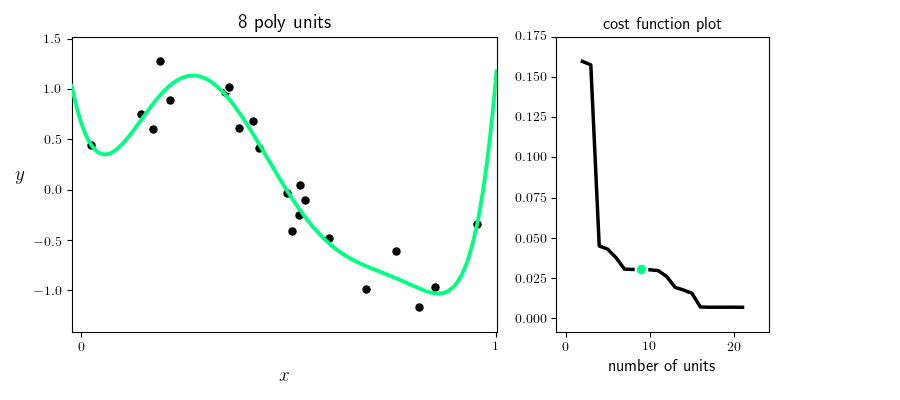
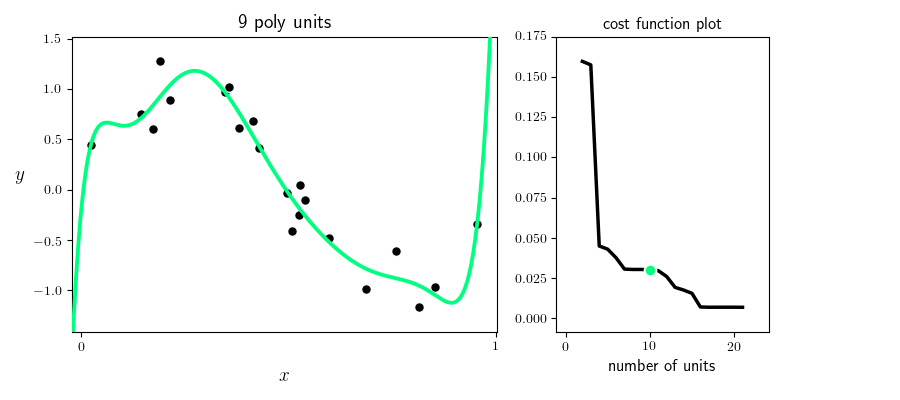
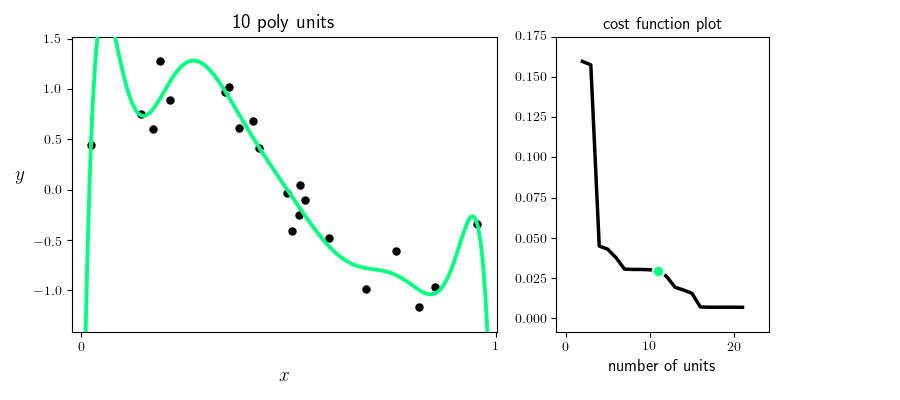
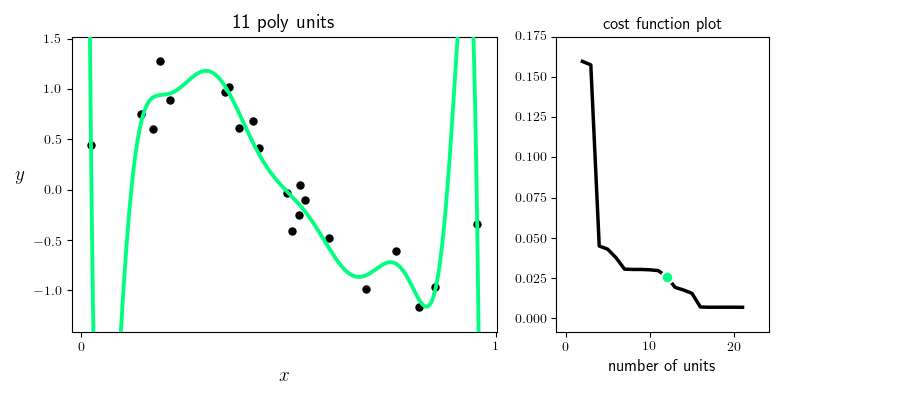
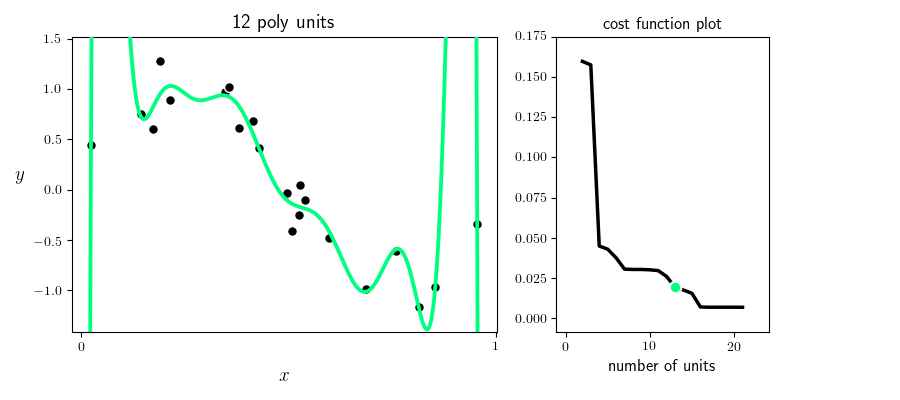
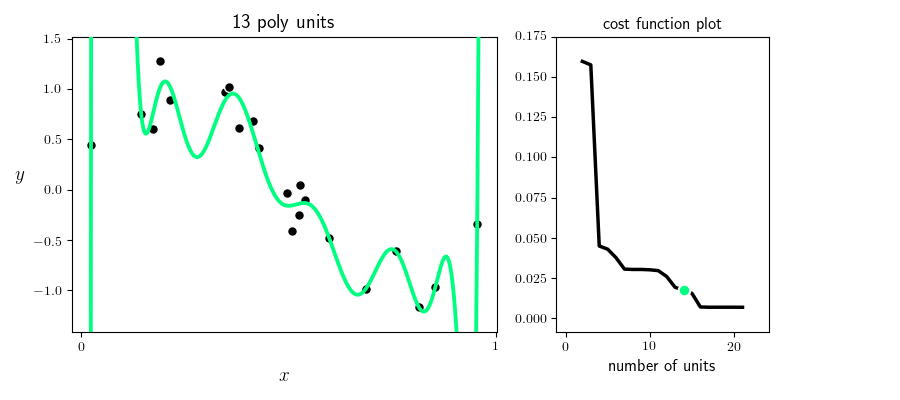
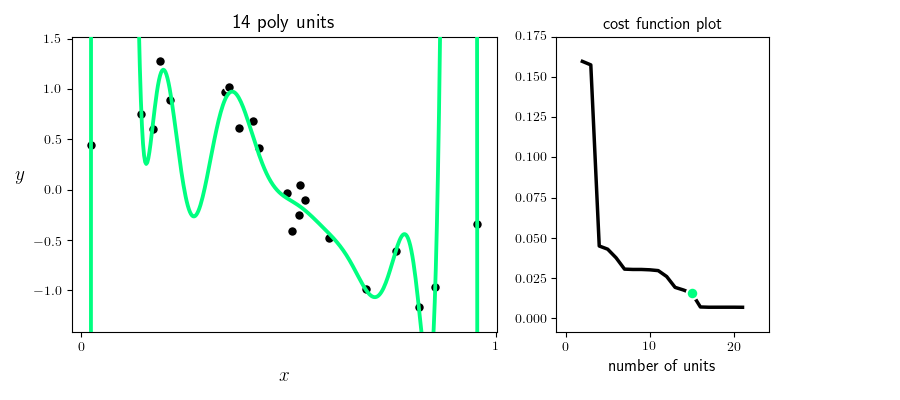
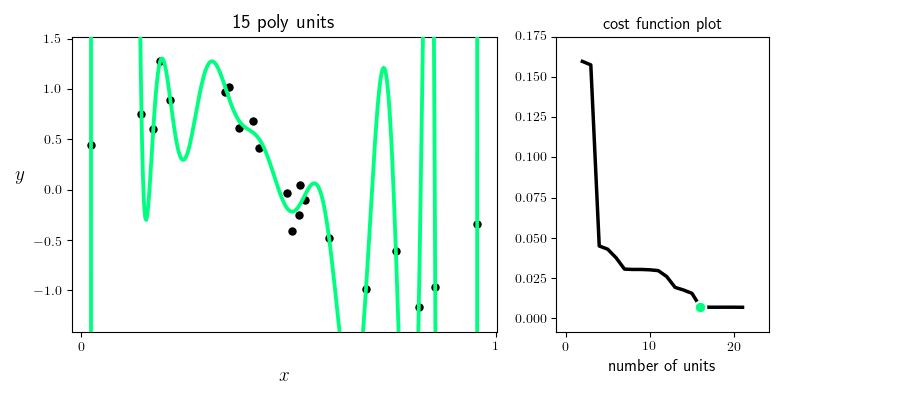
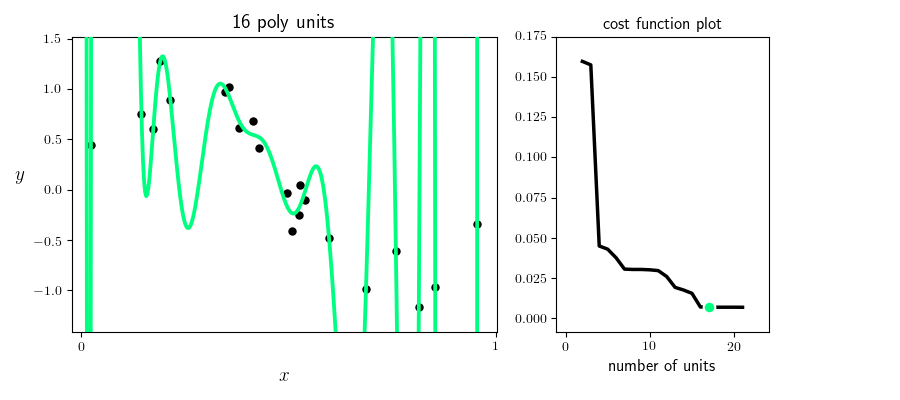
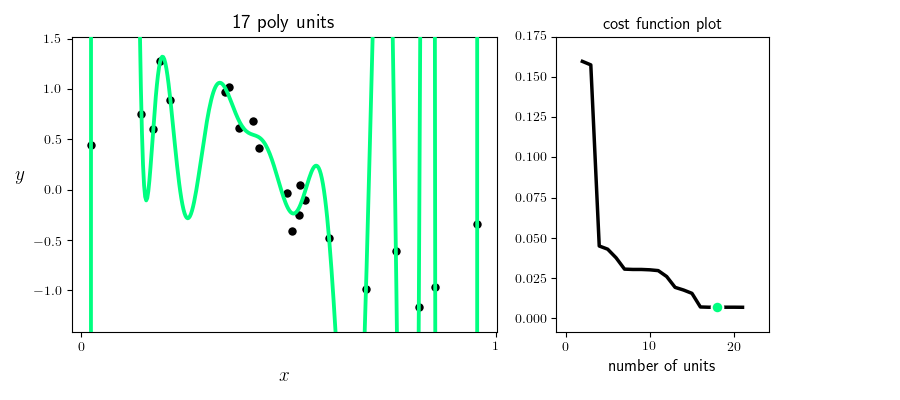
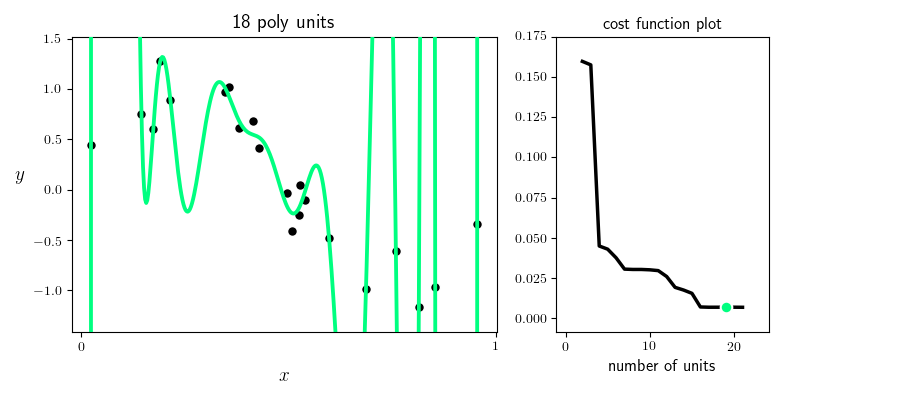
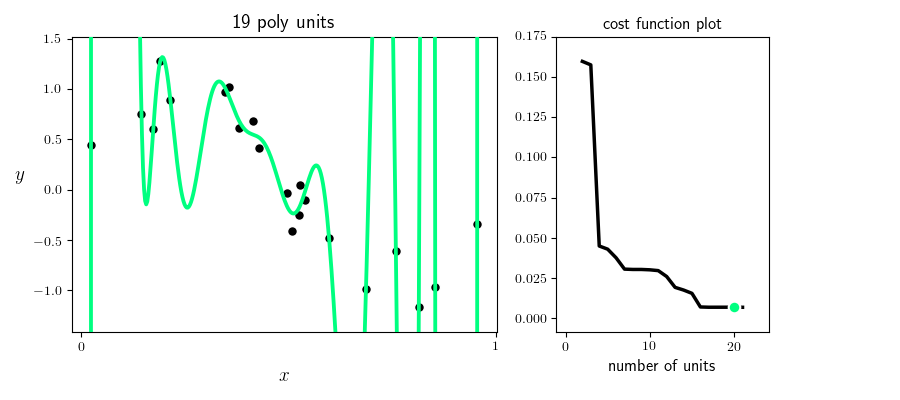
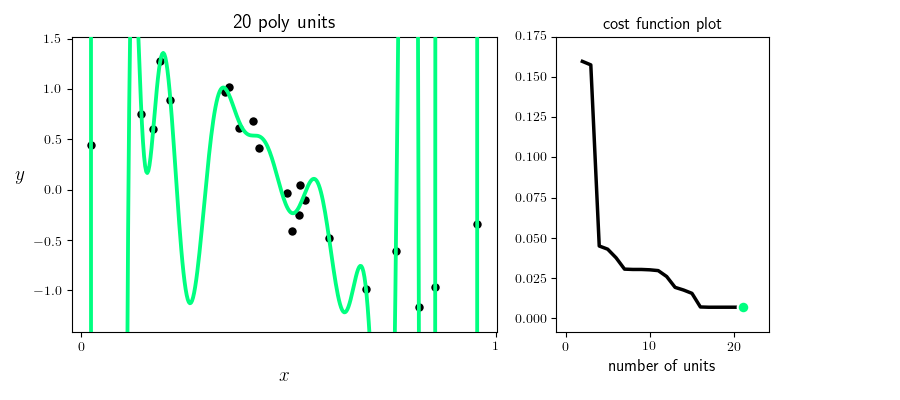

In [16]:
# This code cell will not be shown in the HTML version of this notebook
demo2 = nonlib.regression_basis_single.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo2.load_data(csvname)
demo2.browse_single_fit(basis='poly',num_units = [v for v in range(1,21,1)])

So our main measurement tool - training error - fails to indicate when we have chosen the proper amount of capacity for our model in the case of a real regression dataset (this fact is true more generally as well for other machine learning problems).  Moreover, there is no simple closed form mathematical way of proper model capacity.  This makes quantifying what makes a model "good" for a given dataset a somewhat challenging task at first glance.  It is easier to answer this quandary by tackling its negative: what makes a model "bad" for a given dataset?  

Well we know if a model has *too little* capacity it *underfits* a dataset, meaning that it is too rigid to accurately represent the sort of nonlinearity present in the phenomenon underlying the data.  Conversely if a model has *too much* capacity it *overfits* the data, being too flexible to adequately match the nonlinearity present.  When we as humans visualize a dataset, and a model fit to it, we can *see* how well the model is performing, and so can visually determine if more or less capacity is required.  But we of course cannot / do not want to rely on our visualization skills in general, not only because we cannot visualize most datasets (given that they are too high dimensional), but because our ultimate aim is to automate the process of tuning the capacity of a model correctly.  So how can we codify our abiilty to diagnose what makes a model "bad"?

Below we show three model fits to the regression dataset above.  In the left panel we show a linear model - which we can see *underfits* the data, in the middle panel we show a degree $20$ polynomial model - which cleary *overfits* the data present, and in the right panel we show a degree $3$ polynomial model - which appears to fit quite well.  From studying the left two panels we can ask ourselves: what do both the underfitting and overfitting patterns have in common, that the "just right" model does not?

<IPython.core.display.Javascript object>


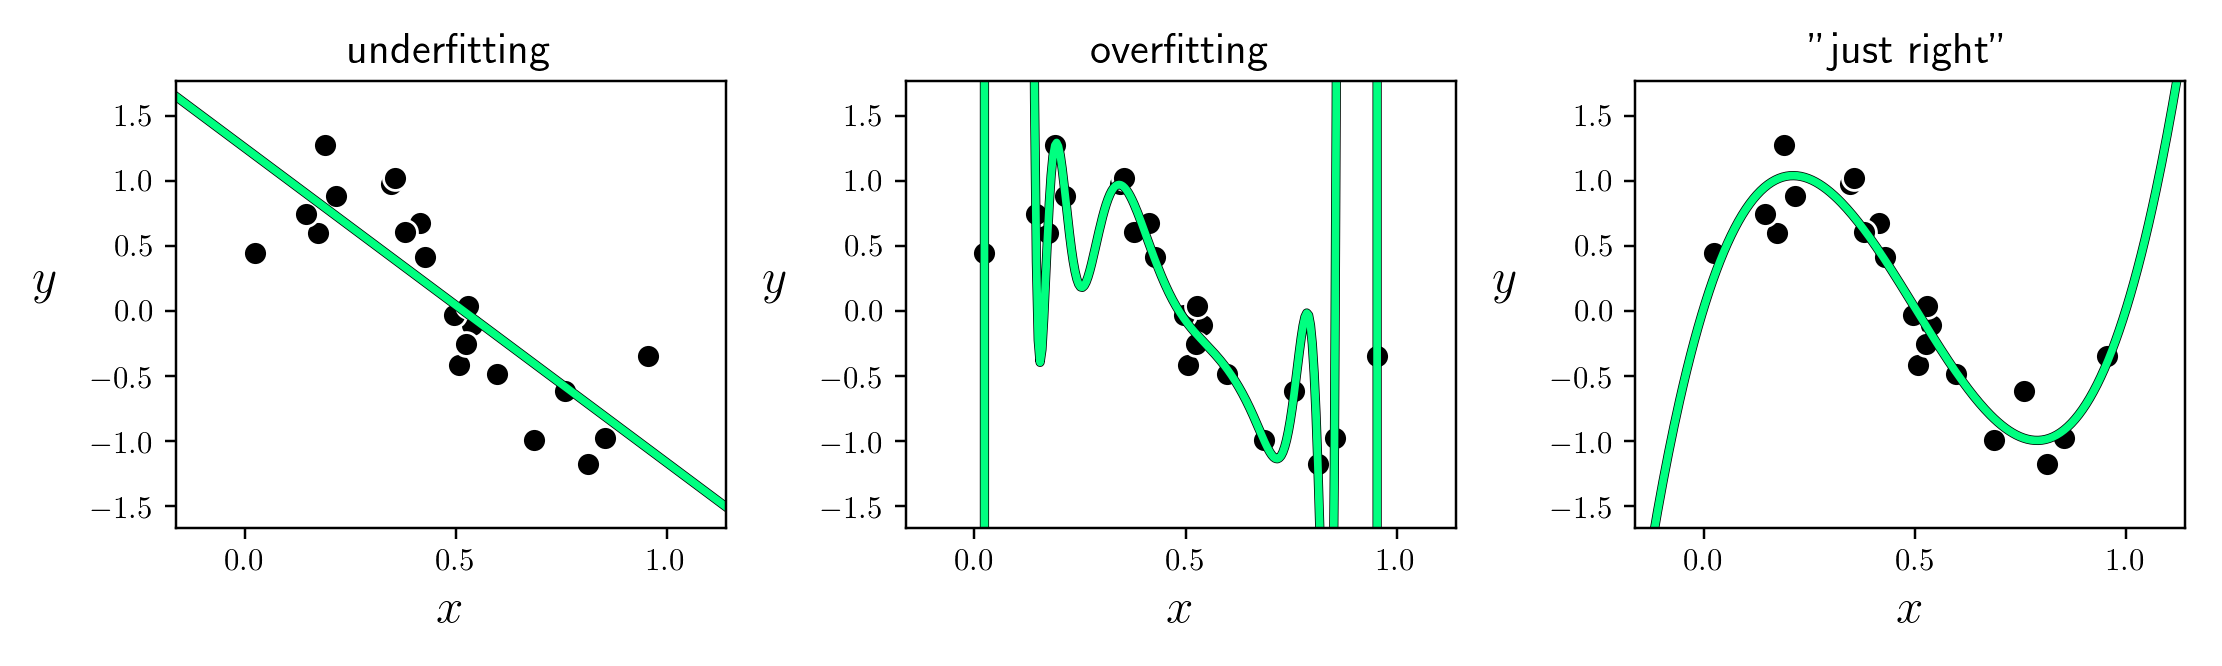

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

### underfitting model ###
# import the v1 library
mylib1 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib1.choose_features(name = 'polys',degree = 1)

# choose normalizer
mylib1.choose_normalizer(name = 'none')

# choose cost
mylib1.choose_cost(name = 'least_squares')

# fit an optimization
mylib1.fit(max_its = 1,optimizer = 'newtons method')

#### overfitting model ####
# import the v1 library
mylib2 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib2.choose_features(name = 'polys',degree = 20)

# choose normalizer
mylib2.choose_normalizer(name = 'standard')

# choose cost
mylib2.choose_cost(name = 'least_squares')

# fit an optimization
mylib2.fit(max_its = 1,optimizer = 'newtons method',epsilon = 10**(-8))

#### just right model ####
# import the v1 library
mylib3 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib3.choose_features(name = 'polys',degree = 3)

# choose normalizer
mylib3.choose_normalizer(name = 'none')

# choose cost
mylib3.choose_cost(name = 'least_squares')

# fit an optimization
mylib3.fit(max_its = 1,optimizer = 'newtons method',epsilon = 10**(-8))

# plot resulting fits
demo5 = regress_plotter.Visualizer(data)
demo5.plot_three_fits(mylib1,mylib2,mylib3)

One thing that clearly differentiates the underfitting and overfitting models: the former does a poor job of representing the data *we already have*, while the latter represents this data very well (indeed too well).  Scanning the left two panels would you agree that one common problem with both the underfitting/overfitting models is that - while they differ in how well they represent data *we already have* - they will both fail to adequately represent *new data*, generated via the same process by which the current data was made?  The data we have clearly follows some sort of wavy sinusoidal pattern - one that is well represented by the models on the right - so if any future data generated by the same process looks at all similar to this neither our underfitting or overfitting models will represent it appropriately.  Another way of thinking about it: we learn regressors to make predictions - so that we can appropriately predict the output for a new input point $x_{\text{new}}$.  Given the data we already have, would we trust either of the underfitting / overfitting model's to perform this task well?  Certainly not.  On the other hand - the "just right" model seems like it would work well as a predictor for future datapoints.  How can we quantify how well a model fits to 'future data'?  We will discuss this below following the next Example.

 #### <span style="color:#a50e3e;">Example 2. </span>   Universal approximation of real classification data

In this example we illustrate the problem of overfitting using a real classification that is based on the near-perfect circular two-class dataset presented in Example 3 of the previous Section.  Here we simulate a real version of this data by randomly selecting $P = 99$ of its points, adding 'noise' by flipping the labels of $5$ points.  

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/Fig_6_5.png' width="75%" height="25%" alt=""/>
</td>
</tr>

<figure>
 <figcaption> <strong>Figure 2:</strong> <em> 
(left panel) The original near-perfect dataset with true circular boundary shown in dashed black from Example 4 of the prior Section.  (right panel) A real dataset formed from a noisy subset of these points.
</em>
</figcaption>
</figure>

In the panels below we show the nonlinear decision boundaries provided by fully tuned models employing $B = 1$ through $B = 20$ polynomial units (left panel), $B = 1$ throught $B = 9$ $\text{tanh}$ neural network units (middle panel), and $B = 1$ through $B = 17$ stump units (right panel), respectively.  At the start all three models *underfit* providing a classification that - in all instances - simply classifies the entire space as belonging to the *blue* class (label values $y = -1$).  Up to a certain point the decision boundary provided by each improves as more units are added, with $B = 5$ polynomial units, $B = 3$ $\text{tanh}$ units, and $B = 5$ stump units providing reasonable approximations to the desired circular decision boundary, respectively.   However soon after we reach these numbers of units each model begins to *overfit* the training data - with the decision boundary of each drifting away from the circular boundary centered at the origin that would properly predict the labels of future data generated by the same underlying phenomenon.  Note: as with regression, this overfitting problem occurs regardless of the sort of universal approximator we use.


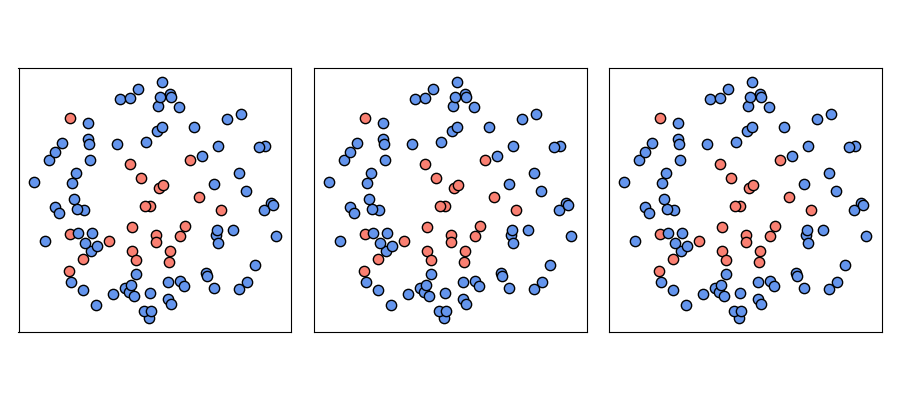
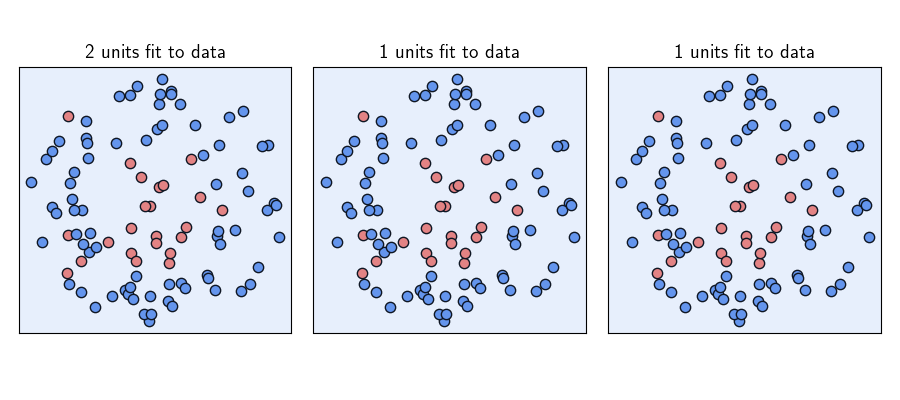
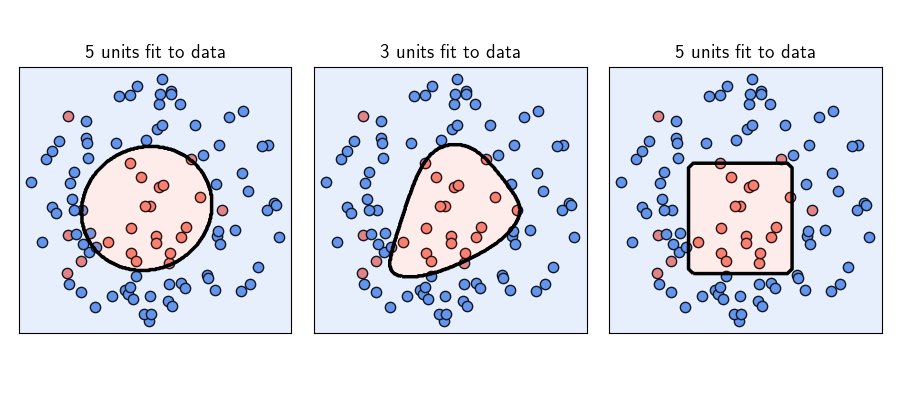
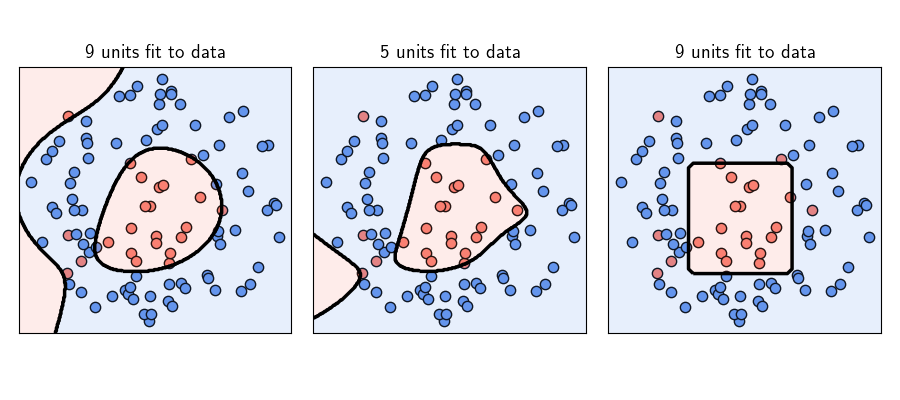
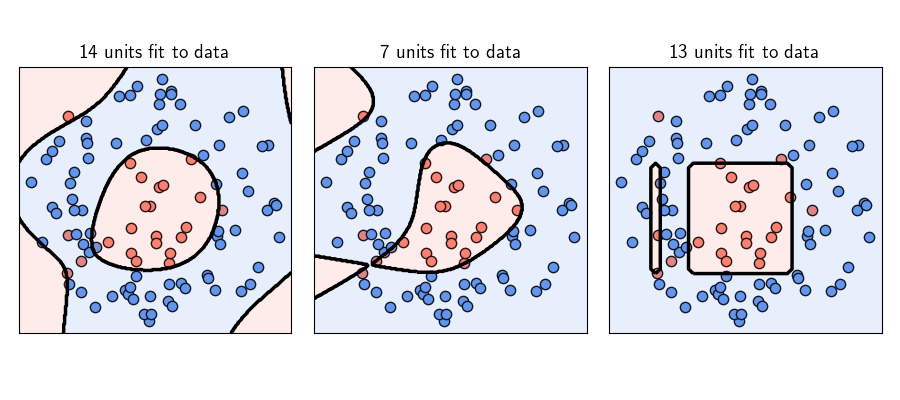
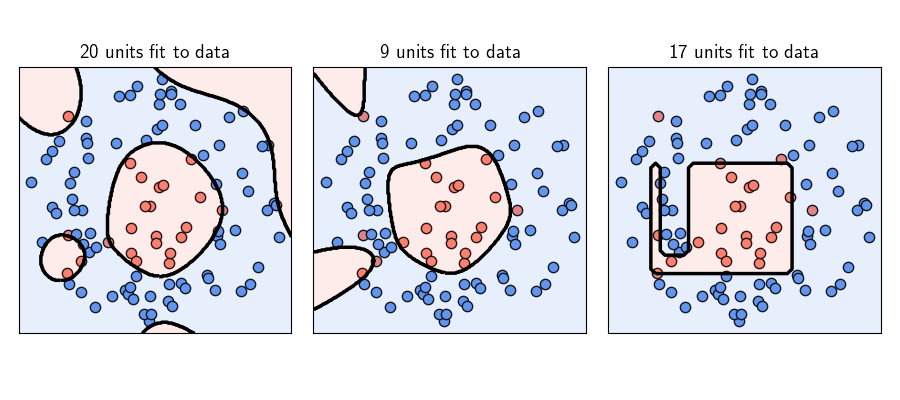

In [74]:
# This code cell will not be shown in the HTML version of this notebook
# load in data
csvname = datapath + 'new_circle_data.csv'
demo3 = nonlib.main_classification_comparison.Visualizer(csvname)

# # run approximators
demo3.runs1 = demo999.run_poly(5)
demo3.runs2 = demo999.run_net(12)
demo3.runs3 = demo999.run_trees(20)

# animate
frames = 5
demo3.animate_comparisons(frames)

In the figure below we plot several of the $\text{tanh}$ neural network-based models shown above (left panel), along with the corresponding Softmax cost value each attains on the training set (right panel).  As you can see adding more $\text{tanh}$ units always *decreases* the cost function value (just as in the 'perfect' data case) - fitting the training data better and better as units are added to the model.  However the resulting fit - after a certain point - actually gets *worse in terms of how it represents the general classification phenomenon*.  Remember that a cost function's value computed over training data - its *training error* - tells us how well our model represents *training data only*, but it does *not* tell us when our model *overfits training data*.


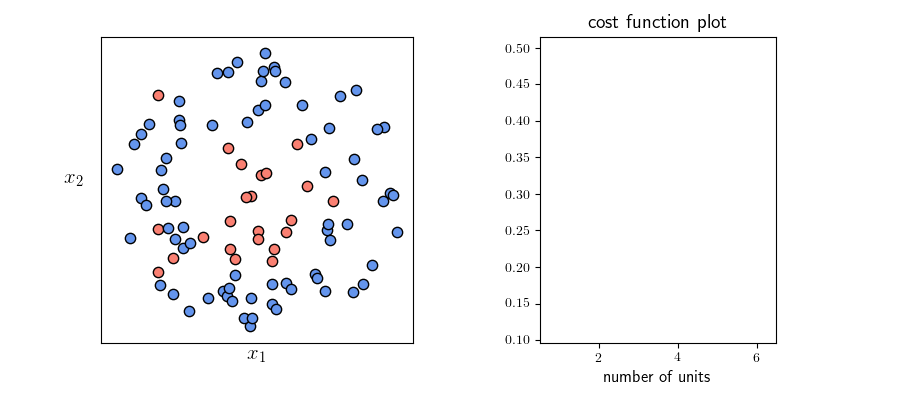
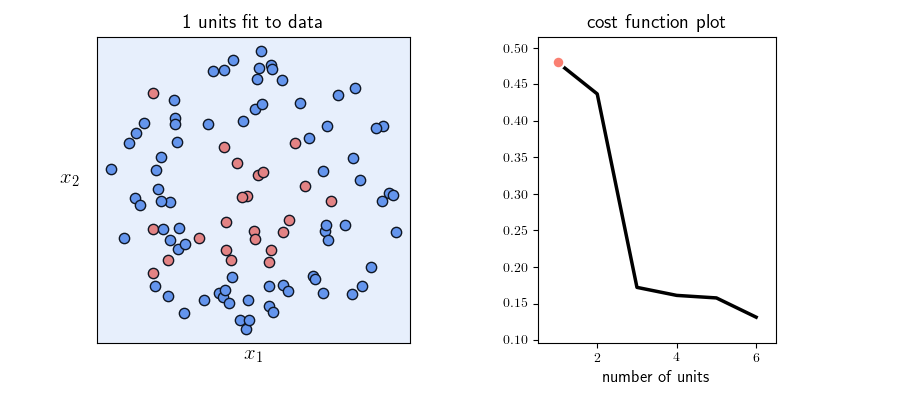
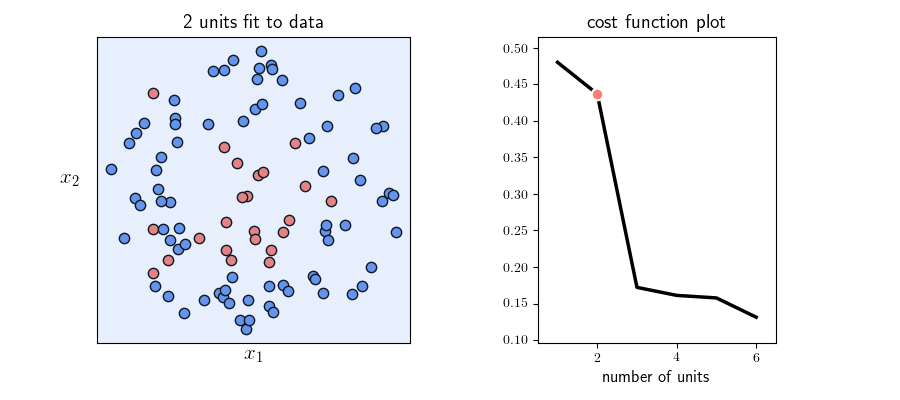
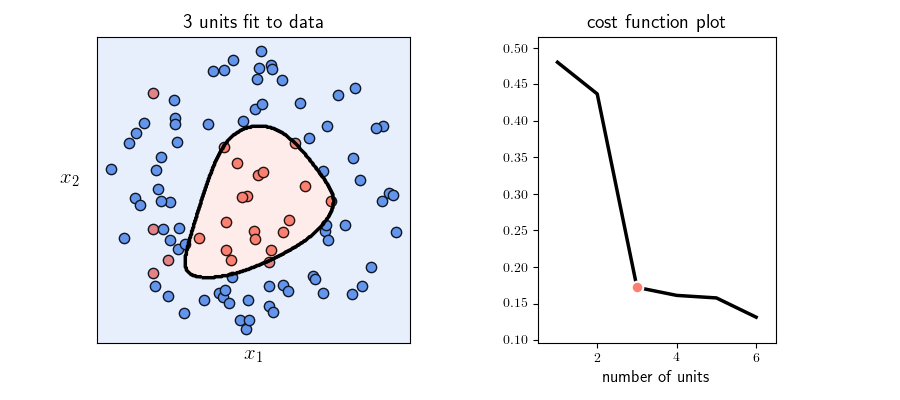
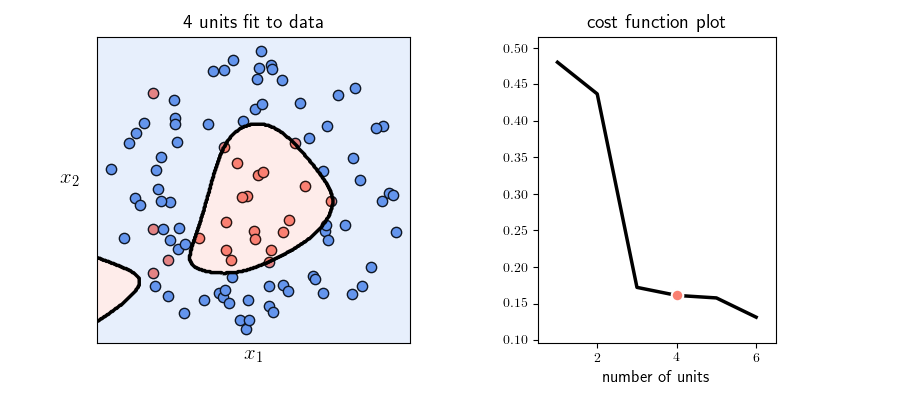
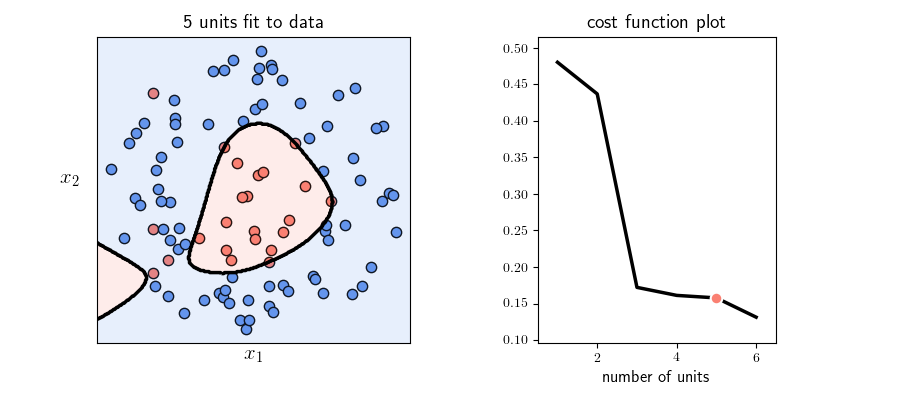
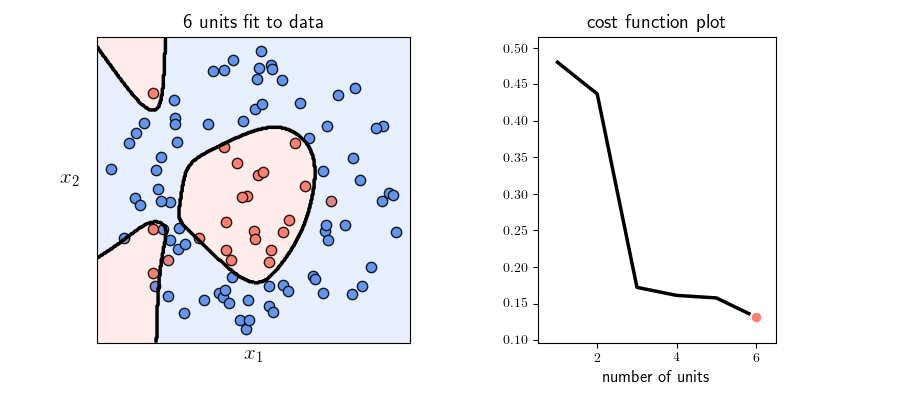

In [21]:
# This code cell will not be shown in the HTML version of this notebook
# load in 
import copy
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
import autograd.numpy as np

# the mid-point between each set of consecutive inputs along each input dimension
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:]

### boosting ###
num_units = 6
run1 = []
for j in range(num_units):
    #print ('fitting ' + str(j + 1) + ' units')
    
    # import the v1 library
    mylib1 = nonlib.library_v1.superlearn_setup.Setup(x,y)

    # choose features
    mylib1.choose_features(name = 'multilayer_perceptron',layer_sizes = [2,j+1,1],activation = 'tanh')

    # choose normalizer
    mylib1.choose_normalizer(name = 'standard')

    # choose cost
    mylib1.choose_cost(name = 'softmax')

    # fit an optimization
    mylib1.fit(max_its = 2000,alpha_choice = 10**(0),optimizer = 'gradient descent')

    # add model to list
    run1.append(copy.deepcopy(mylib1))
    
# animate the business
frames = num_units
demo4 = nonlib.main_classification_animators.Visualizer(csvname)
demo4.animate_classifications(run1,frames)

So once again we see that training error fails as a measurement tool in that it does not tell us when we have set the capacity of our model 'just right'.  What makes a model capacity 'just right'?  Below we show an underifitting (left panel), overfitting (middle panel), and 'just right' (right panel) model for the two-class classification dataset above.  These were created using a linear, degree 15 polynomial, and degree 2 polynomial model respectively.  Notice here that the underfitting linear model just classifies everything as part of the blue class.  As with the regression dataset in the previous Example we can ask ourselves: studying the left two panels what do both the underfitting and overfitting patterns have in common, that the 'just right' model does not?

<IPython.core.display.Javascript object>


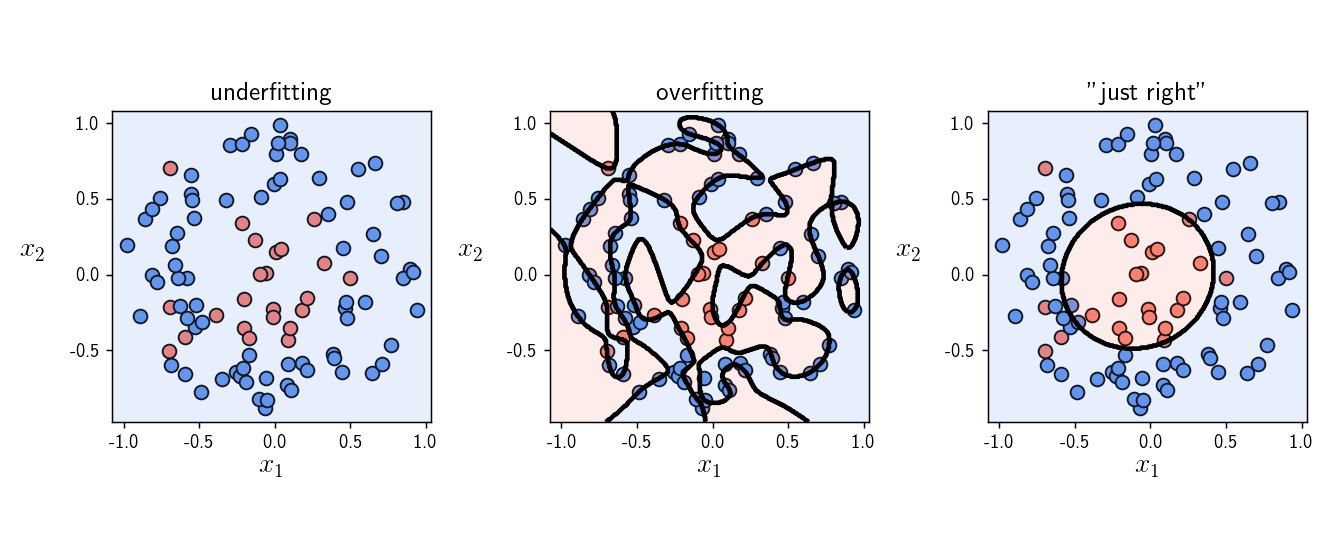

In [43]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

### underfitting model ###
# import the v1 library
mylib4 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib4.choose_features(name = 'polys',degree = 1)

# choose normalizer
mylib4.choose_normalizer(name = 'none')

# choose cost
mylib4.choose_cost(name = 'softmax')

# fit an optimization
mylib4.fit(max_its = 10,optimizer = 'newtons method')

#### overfitting model ####
# import the v1 library
mylib5 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib5.choose_features(name = 'polys',degree = 15)

# choose normalizer
mylib5.choose_normalizer(name = 'none')

# choose cost
mylib5.choose_cost(name = 'softmax')

# fit an optimization
mylib5.fit(max_its = 10,optimizer = 'newtons method',epsilon = 10**(-17))

#### just right model ####
# import the v1 library
mylib6 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib6.choose_features(name = 'polys',degree = 2)

# choose normalizer
mylib6.choose_normalizer(name = 'none')

# choose cost
mylib6.choose_cost(name = 'softmax')

# fit an optimization
mylib6.fit(max_its = 10,optimizer = 'newtons method',epsilon = 10**(-17))

# plot resulting fits
demo6 = classif_plotter.Visualizer(csvname)
demo6.plot_three_fits(mylib4,mylib5,mylib6)

Again - as with regression in the previous Example - we could say that clearly the underfitting model fails to represent data we *already have*, while the overfitting model fits our current data very well (all of the points are indeed classified correctly).  Once again however both the underfitting/overfitting models both will fail to adequately represent *new data*, generated via the same process by which the current data was made.   The data we have is largely separated by a circular boundary  - one like the one found by the model on the right - so if any future data generated by the same process looks similar, neither our underfitting nor overfitting models will appropriately represent it.  

Our problem now is that we do not yet have a measurement tool that tells us how well a model performs on 'data we might receive in the future'.  Our *training error* measurement (that is, the measure of how well a tuned model fits the training data) does *not* tell us how well our model represents the phenomenon generating our data only how well it represents the training data.   We need a new way of measuring this aspect of a tuned model, which we describe below.

---

As we have seen in the examples above, unlike the case with perfect data, with real data in  we need to carefully set the capacity of our model and tune its parameters appropriately in order to produce a model that represents the phenomenon generating our data well.  In the jargon of machine learning this desire - to set the capacity *just right* - often goes by the name the *bias-variance trade-off*.  A model with too little capacity is said to *underfit* the data, or to have *high bias*.  Conversely, a model with too much capacity is said to *overfit* the data, or have *high variance*.  This pursuit is often referred to sweepingly as the bias-variance trade-off, i.e., the pursuit of a model that has neither too little capacity ('high bias' or underfitting) nor too much capacity ('high variance' or overfitting).

## 11.2.2  Validation error as a measurement tool

We now have a general diagnosis for the problem of underfitting / overfitting, that such a model does not accurately represent new data we might receive in the future.  But how can we make use of this diagnosis - we of course do not have access to any "new data we will receive in the future".  To make this notion useful we need to translate it into a quantity we can always measure regardless of the dataset / problem we are tackling or model we employ.  

The universal way to do this is to simply remove a *random* portion of our training data and treat it (prettend it) is 'new data we might receive in the future' (illustrated abstractly in the Figure below).  In other words we cut out a random chunk of the dataset we have, train our selection of models on only the data that remains, and *validate* the performance of each model on this randomly removed chunk of 'new' data.  The portion of our data that remains for use to train our models is referred to as the *training data (or training set)*, with the portion used to *validate* the effecacy of each model referred to as the *validation data (or validation set)*.   So in other words, we determine the best choice from a selection of models by choosing the one with the *lowest error on the validation data* - or the one with the *lowest validation error*.   Choosing a 'best model' employing a measurement tool like validation error is generally referred to as *cross-validation*.  We describe two fundamental approaches to effective cross-validation in the two Sections following this one.

Validation error - unlike training error - is in fact a proper measurement tool for determining the quality of a model against the underlying data generating phenomenon we want to capture. 


<figure>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/Fig_5_15.png' width="60%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 4:</strong> <em> Splitting the data into testing and validation sets.  The original data (left panel) shown here as the entire circular mass is split randomly (middle panel) into $k$ non-overlapping sets (here $k=3$). (right panel) One piece, or $\frac{1}{k}$ of the original dataset, is then taken randomly as the testing set with the remaining pieces, or $\frac{k-1}{k}$ of the original data, taken as the training set. </em>  </figcaption> 
</figure>

What portion of our dataset should we save for validation? There is no hard rule, and in practice typically between $\frac{1}{10}$ to $\frac{1}{3}$ of the data is assigned to the validation set.  When deciding what portion of the original training data to remove for validation, remember that this chunk as data we 'will receive in the future'.  Thus, generally speaking, the larger and /or more representative (of the true phenomenon from which the data is sampled) data the *larger* the portion of the original data may be assigned to the validation set (e.g., $\frac{1}{3}$ may be placed in the validation set).  The intuition here for doing this is that if the data is plentiful / representative enough, the training data still accurately represents the underlying phenomenon. Conversely, in general with smaller or less rich (i.e., more noisy or poorly distributed) datasets we should take a smaller portion for validation (e.g., $\frac{1}{10}$) since the relatively larger training set needs to retain what little information of the underlying phenomenon was captured by the original data.

## 11.2.3  Cross validation

Validation error is naturally superior to training error as a measurement tool to help us determine when the capacity of a nonlinear model is set 'just right' (i.e., so that the model does not underfit or overfit a dataset).  However validation error does not directly tell us what kind of model we need, it simply provides us with a way of *comparing two or more fully trained models* in terms of how well they represent a given dataet - the one with lowest validation error being the best choice.  

This naturally means that in order to leverage validation error as a measurement tool for determining the best model for a dataset *we must train a range of nonlinear models*, the best model for the data being the one that provides the lowest validation error of those we trained.  This process - of training a range of models to determine the best some error measurement tool (like validation error) - is often referred to as *cross-validation*, *model selection*, or *model search*.  Each model trained in performing cross-validation in this way is virtually always built using units from a single type of universal approximator (i.e., kernels, neural networks, or trees).   Because each main family of universal approximators have their own technical eccentricities, as detailed in Chapters 12 - 14, doing this helps us better organize our model search.


By its vary nature, since a range of models are trained on a single dataset, cross-validation is often the most computationally intensive component of a machine learning pipeline.  Indeed without careful consideration the cost (computationally speaking) of cross-validation can easily get out of hand.  In the next two Sections we describe two general and popular frameworks for effecient model search, but first below we walk through several simple examples / sets of models to more fully flush out the intuition behind cross-validation.

#### <span style="color:#a50e3e;">Example 3. </span>  A simple regression cross-validation example

In this example we illustrate the use of the training / validation data split detailed above on the $N=1$ dimensional input sinusoidal regression dataset introduced in Example 1 above.  Here we use $\frac{2}{3}$ of the original set of $21$ data points for training, and the other $\frac{1}{3}$ for validation.  The set of models we compare here are complete polynomials of degree $B = 1,...,8$.  In other words, the degree $B$ model takes the form  


\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + x{w}_{1} +  x^2{w}_{2} + \cdots + x^B{w}_B.
\end{equation}

Note how this small set of models is naturally ordered in terms of nonlinear capacity - with lower degree models have smaller capacity and larger degree models have higher capacity.


Moving the slider from left to right below shows the fit of each polynomial model from degree $1$ to $8$ sequentially on the original dataset (upper left panel), training data (top right panel), and validation data (bottom left panel).  The errors on both the training (shown in blue) and validation (shown in yellow) data is shown in the bottom right panel.  

Pulling the slider from left to right, notice that then the validation error is at its *lowest* - that is, the error on our set of data we are pretending to receive in the future - that indeed the model providing this measurement is indeed a good fit to the entire dataset.  Here that model is a degree $3$ polynoimal.  Of course as we use more and more polynomial units - mmoving the slider from left to right - the fit to the training data continues to decrease since the higher degree models will indeed fit it better and better.  However as the training error continues to decrease, the corresponding validation error starts climbing rapidly as the corresponding models become a poorer and poorer representation of the validation data (by degree $B = 7$ the validation error becomes so large that we do not plot it in the same window for visualization purposes, so that the other error values can be distinguished properly).


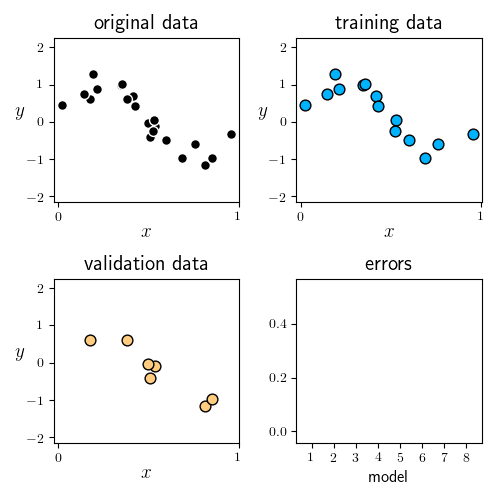
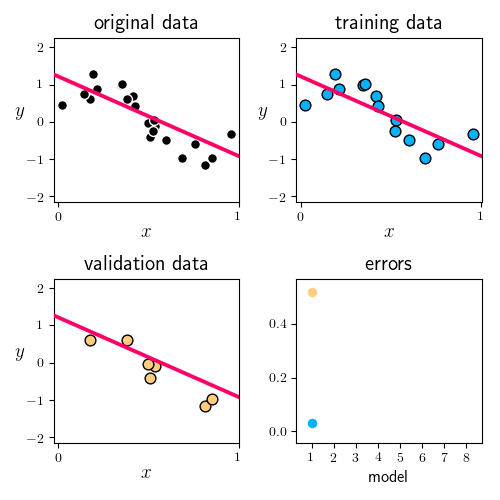
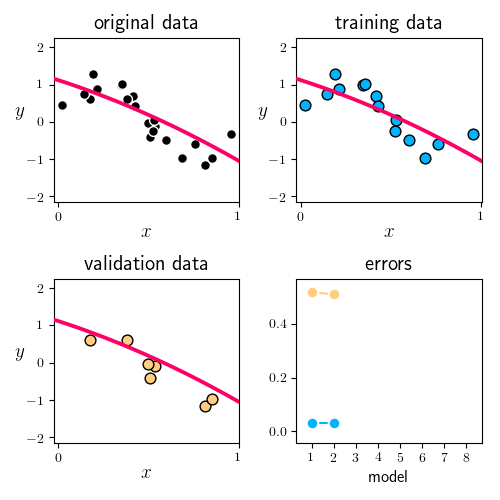
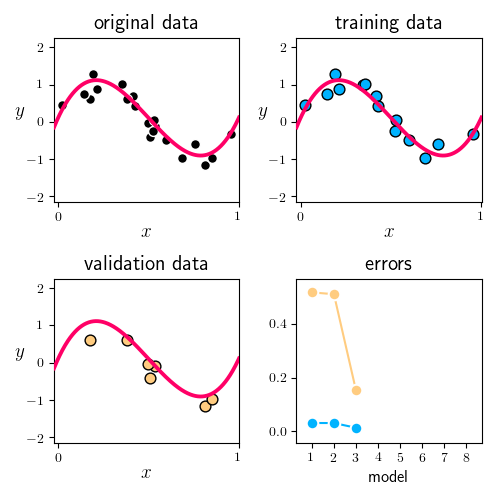
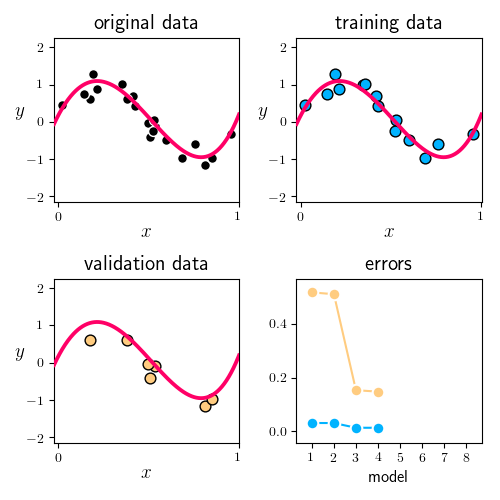
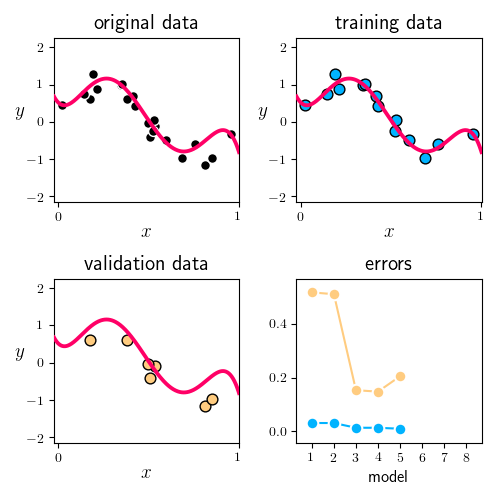
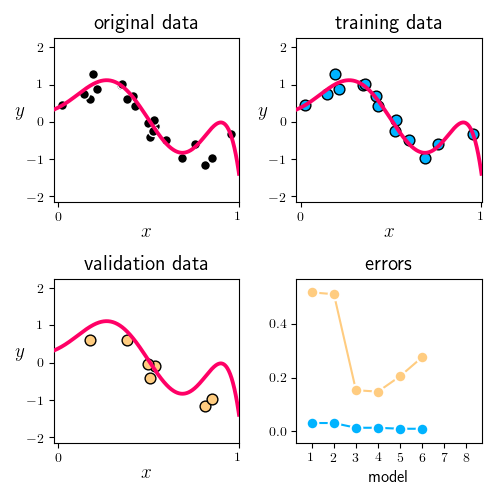
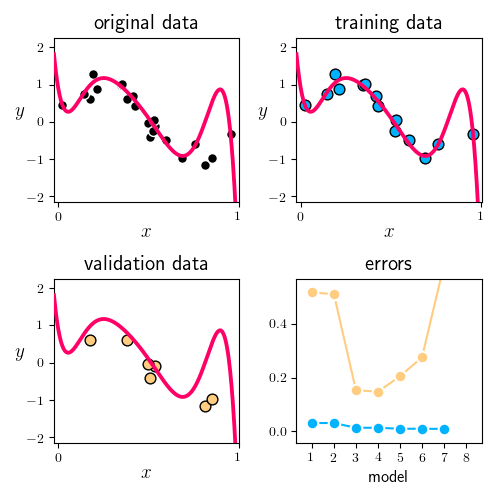
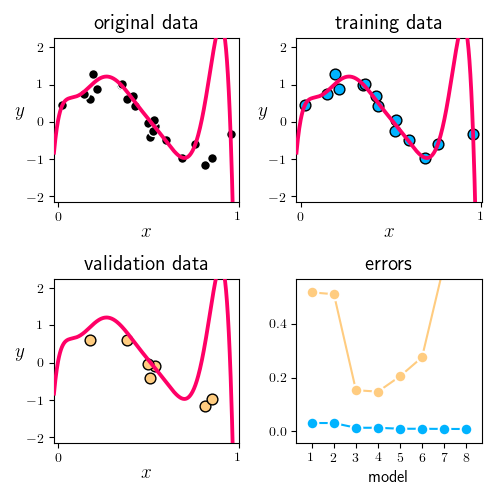

In [152]:
## This code cell will not be shown in the HTML version of this notebook
# run demonstration
demo3 = nonlib.regression_basis_single.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo3.load_data(csvname)
demo3.brows_single_cross_val(basis='poly',num_elements = [v for v in range(1,9)],folds = 3)

#### <span style="color:#a50e3e;">Example 4. </span>  A simple two-class classification cross-validation example

In this example we illustrate the use of the training / validation data split detailed above for the classification dataset first shown in Example 2.  Here we use $\frac{4}{5}$ of the original set of $99$ data points for training, and the other $\frac{1}{5}$ for validation.  Once again - for the sake of simplicity - we employ a small set of polynomial models ranging in the following degrees $B = 1,...,7$.  Note because the input here $N=2$ dimensional and we are using full degree polynomial models, the number of units in each successive model increases by more than $1$ unit at a time.  Indeed one can compute that a full degree $d$ polynomial model - which in this instance consists of all units of the form 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + \sum_{i+j\,\leq \, B} w_{i,\,j}x_1^{\,i}x_2^{\,j}
\end{equation}

consists of $\binom{2+B}{B} - 1$ monomial units.

Once again we animate the complete fit of each model to the training data, showing each complete fit and the original data (in the top left panel), and the training data (top right panel), and the validation data (bottom left panel).  The training and validation error is likewise shown in the bottom right panel.  Notice as you pull the slider from left to right the resulting fit and errors of each subsequent model are shown sequentially from degree $B = 1$ to degree $B = 7$.  Also notice here that with classification it makes more sense to use the number of misclassifications computed over the training / validation sets (or some function of these misclassifications, like accuracy - see Section 6.7) as our training / validation errors, as opposed to the evaluation of a classification cost. 

Notice how the model that provides the smallest validation error - here the degree $B = 2$ polynomial - provides the best nonlinear decision boundary for the entire dataset.  This result makes intuitive sense as well, as we determined a circular boundary using a model of this form when engineering such features in Example 3 of Section 10.3.  As the training error continues to decrease we *overfit* it, with such models providing a poor solution for the validation data.


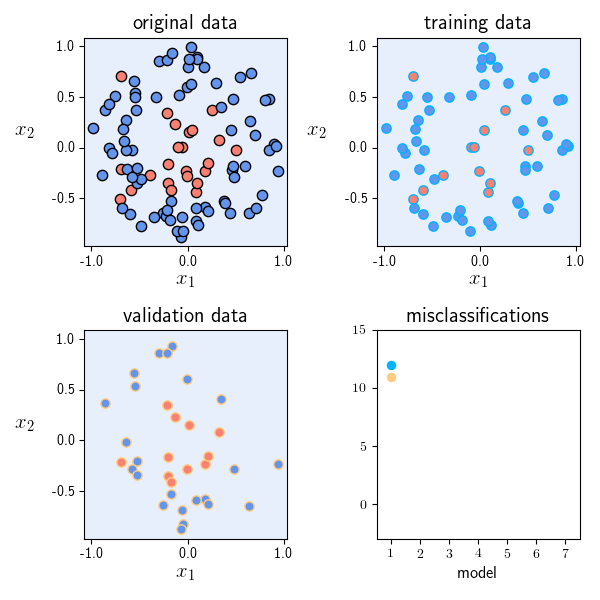
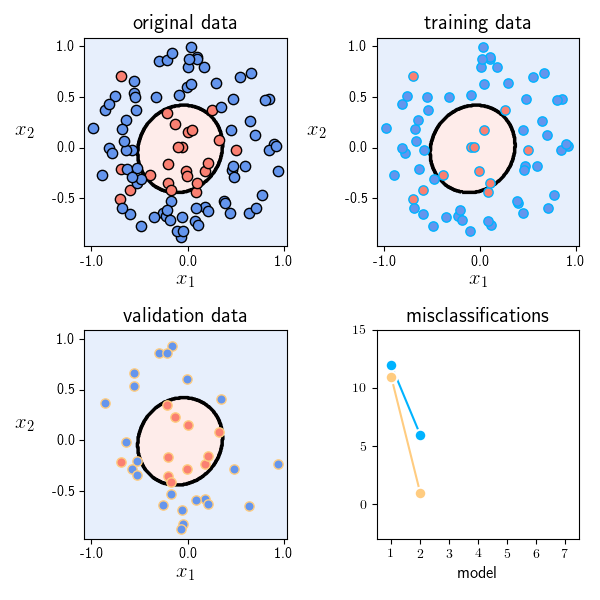
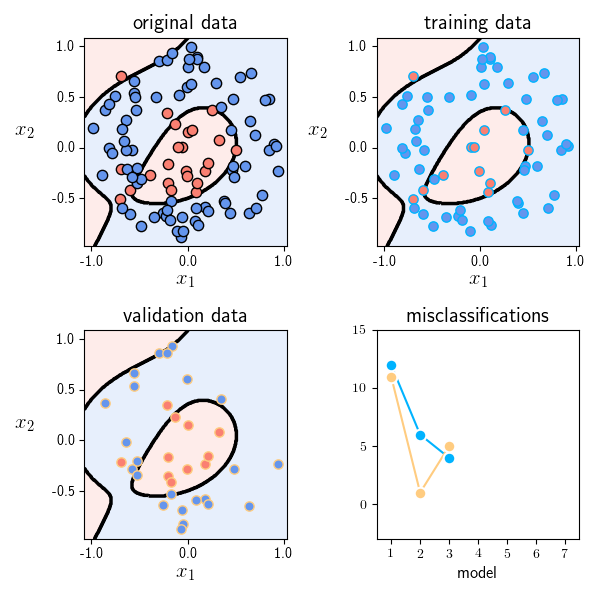
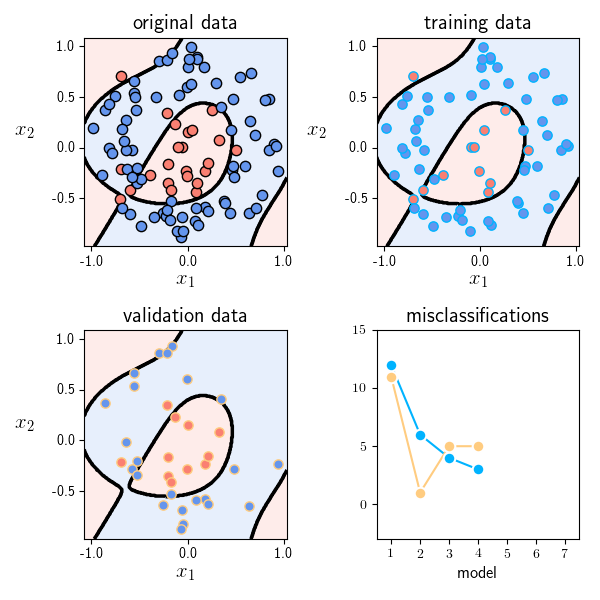
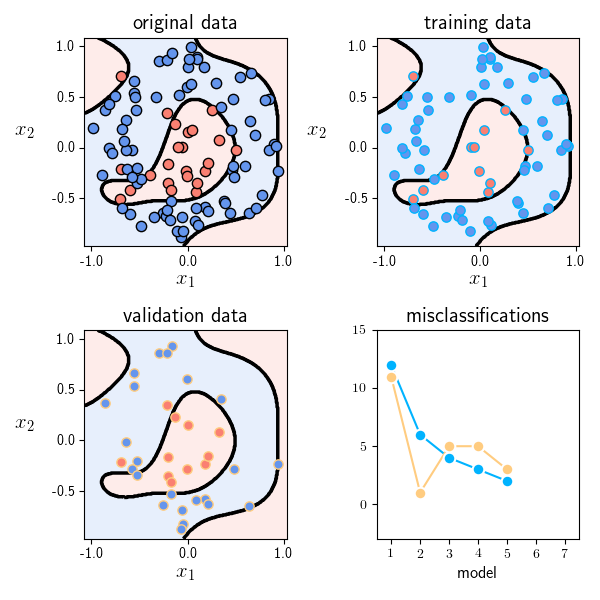
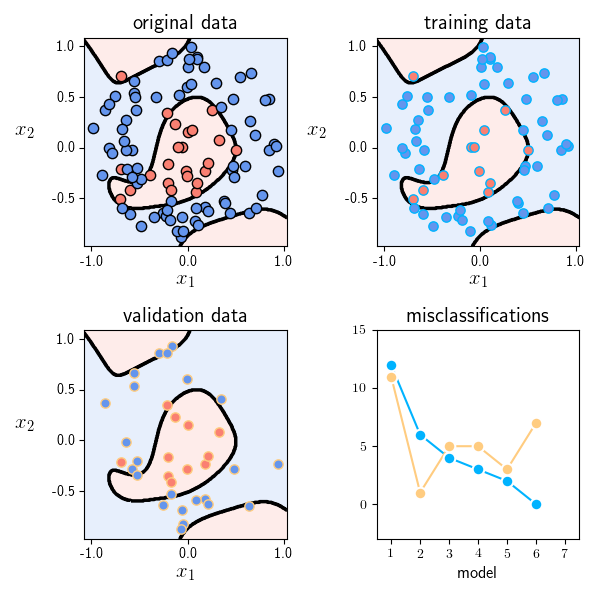
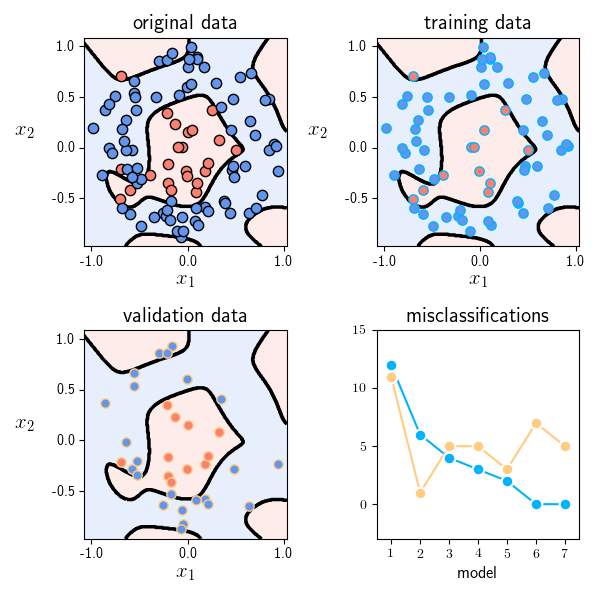

In [165]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

### run cross validation experiments ###
degrees = np.arange(1,8)
models_1 = []
for j in degrees:
    # import the v1 library
    mylib7 = nonlib.library_v2.superlearn_setup.Setup(x,y)

    # choose features
    mylib7.choose_features(name = 'polys',degree = j)
    
    # choose normalizer
    mylib7.choose_normalizer(name = 'none')

    # split into training and testing sets
    if j == 1:
        mylib7.make_train_valid_split(train_portion = 0.66)
        x_train = mylib7.x_train
        y_train = mylib7.y_train
        x_valid = mylib7.x_valid
        y_valid = mylib7.y_valid
    else: # use split from first run for all further runs
        mylib7.x_train = x_train
        mylib7.y_train = y_train
        mylib7.x_valid = x_valid
        mylib7.y_valid = y_valid

    # choose cost
    mylib7.choose_cost(name = 'softmax')

    # fit an optimization
    mylib7.fit(optimizer = 'newtons_method',max_its = 5,epsilon = 10**(-8))

    # add model to list
    models_1.append(mylib7)

# load up animator
csvname = datapath + 'new_circle_data.csv'
demo4 = nonlib.crossval_classification_animator.Visualizer(csvname)

# animate based on the sample weight history
demo4.animate_crossval_classifications(models_1)

#### <span style="color:#a50e3e;">Example 5. </span>  A simple multi-class classification cross-validation example

In this example we illustrate the use of the training / validation data split detailed above for the classification dataset first shown in Example 1 of Section 10.4.  Here we use $\frac{4}{5}$ of the original set of $99$ data points for training, and the other $\frac{1}{5}$ for validation.  We employ a small set of polynomial models ranging in the following degrees $B = 1,...,4$.  We show the complete fit of each model to the training data, showing each complete fit and the original data (in the top left panel), and the training data (top right panel), and the validation data (bottom left panel).  The training and validation error is likewise shown in the bottom right panel.  Notice as you pull the slider from left to right the resulting fit and errors of each subsequent model are shown sequentially from degree $B = 1$ to degree $B = 4$.  Here - as in the previous Example - it makes more sense to use the number of misclassifications computed over the training / validation sets (or some function of these misclassifications, like accuracy - see Section 7.5) as our training / validation errors, as opposed to the evaluation of a multi-class classification cost. 

Here the degree $B = 2$ polynomial model provides the best nonlinear decision boundary for the entire dataset, as it achieves the lowest validation error.  This result makes intuitive sense as well, as we determined this was an appopriate model for this dataset by feature engineering in Section 10.4.  


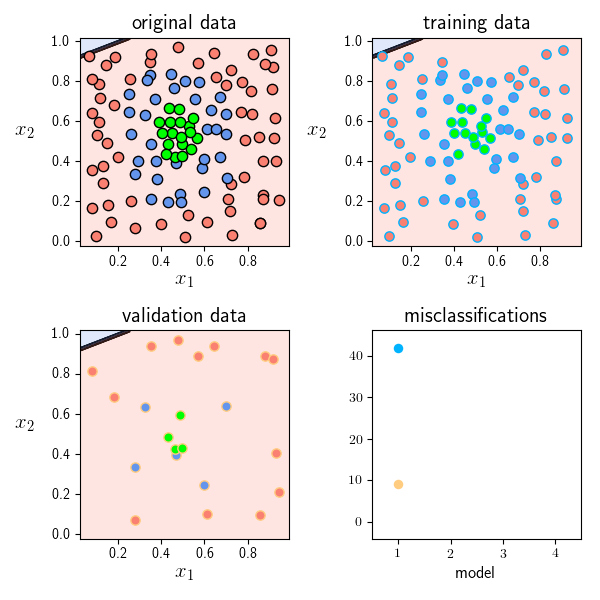
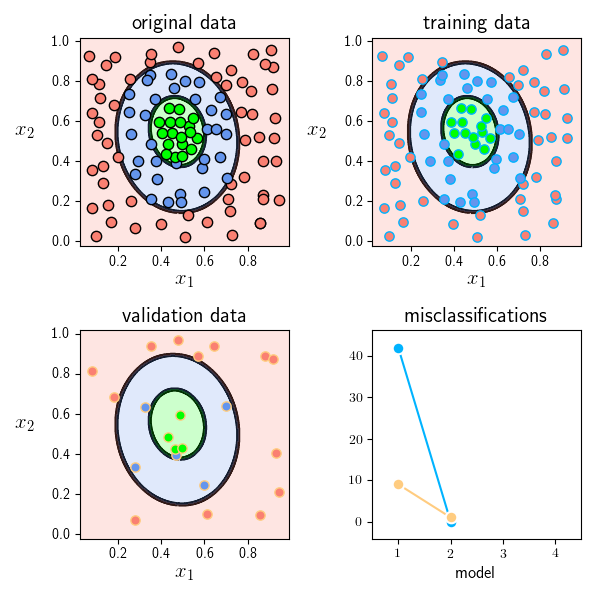
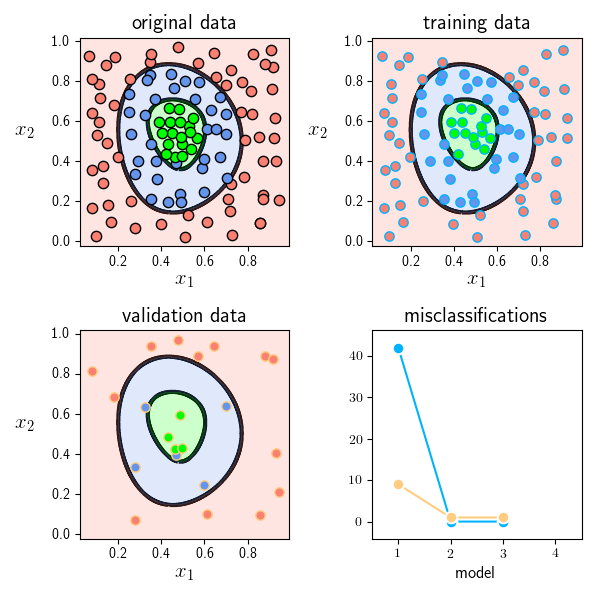
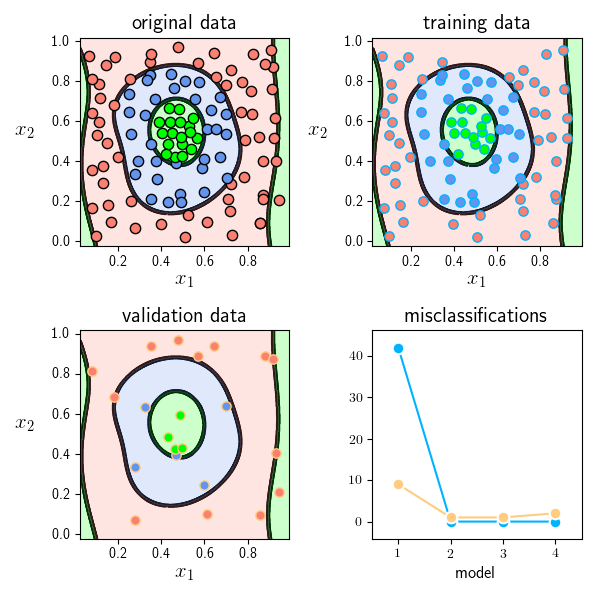

In [168]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + '3_layercake_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

### run cross validation experiments ###
max_units = 5
degrees = np.arange(1,max_units)
models_2 = []
for j in degrees:
    # import the v1 library
    mylib8 = nonlib.library_v2.superlearn_setup.Setup(x,y)

    # choose features
    mylib8.choose_features(name = 'polys',degree = j,num_classifiers = 3)
    
    # choose normalizer
    mylib8.choose_normalizer(name = 'standard')

    # split into training and testing sets
    if j == 1:
        mylib8.make_train_valid_split(train_portion = 0.8)
        x_train = mylib8.x_train
        y_train = mylib8.y_train
        x_valid = mylib8.x_valid
        y_valid = mylib8.y_valid
    else: # use split from first run for all further runs
        mylib8.x_train = x_train
        mylib8.y_train = y_train
        mylib8.x_valid = x_valid
        mylib8.y_valid = y_valid

    # choose cost
    mylib8.choose_cost(name = 'multiclass_softmax')

    # fit an optimization
    mylib8.fit(optimizer = 'newtons_method',max_its = 10,epsilon = 10**(-8))

    # add model to list
    models_2.append(mylib8)
    
### animate training / validation errors ###

### animate training / validation errors ###
# load up animator
csvname = datapath + '3_layercake_data.csv'

demo5 = nonlib.crossval_classification_animator.Visualizer(csvname)

# animate based on the sample weight history
demo5.animate_multiclass_crossval_classifications(models_2)

## 11.2.4  Which universal approximator works best in practice?

While some guidance can be given in certain situations regarding the best universal approximator to employ - i.e., kernels, neural networks, or trees - no general rule exists for which approximator one should use in all instances of nonlinear learning to construct models / perform cross-validation with. Indeed for an arbitrary dataset it very well may be the case that - in terms of representation quality - that no universal approximator performs especially better than any other. However in some instances understanding of the phenomenon underlying the data, the need for human interpretability, and/or practical considerations can drive the choice of universal approximators used in cross-validation.

### Data understanding and convention

Gathering some understanding of a dataset or phenomenon underlying it, while not always easy to glean, can be a very effective way of deducing the effectiveness of a particular universal approximator.  This is particularly true with *regression problems*.  For example, *tree-based* approximators are often quite effective with business, census, and other kinds of *metadata* datasets.  Such data often consists of various discontinuous input features - like e.g., categorical variables (see e.g., Section 9.1) - that are modeled quite effectively by the step-like shapes provided by *tree-based universal approximators*.  As another example, periodic universal approximators  (nonlinearities that repeat themselves on regular intervals) - whether they be neural networks with sinuoidal activation or the Fourier kernel as detailed in Chapter 12 - are intuitively appropriate and often perform very well when dealing with data generated from a known periodic phenomenon like e.g., weather patterns, audio data, etc., 

With the exception of metadata datasets (where again trees often provide the best performance), due to the nature of classification problems it is less common (than with regression) that domain knowledge leads to a particular choice of basis. Rather in practice it is more common to employ knowledge in the design of a feature transformation (like those discussed for text, image, or audio data in Section 9.2), and then determine possible nonlinear boundaries in this transformed data using a universal approximator as described in this Chapter. For certain data types such as image data one can incorporate a parameterized transformation that outlines the sort of edge detection/histogramming operations outlined in Section 9.2 directly into basis elements themselves. Parameters of this transformation are then learned simultaneously with those of the weighted basis sum itself. A popular example of this sort of approach is the convolutional network which incorporates such (parameterized) knowledge-driven features into a standard feed forward neural network basis.

Regardless of how knowledge is integrated, having some understanding of a phenomenon can significantly lessen the amount of data required to produce a k-fold representation that properly traces out a data generating function. On the other hand, broadly speaking if we have no understanding of a phenomenon we will typically require significant amount of data in order to ensure that the features we have designed through the k-fold process are truly representative. What constitutes a 'significant amount'? There is no precise formula in general, however due to the curse of dimensionality we can say that the higher the dimension of the input the exponentially more data we will need to properly understand the underlying function.

This data-knowledge tradeoff is illustrated symbolically in the Figure.

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/knowledge_spectrum.png' width="90%" height="25%" alt=""/>
</td>
</tr>

<figure>
 <figcaption> <strong>Figure 3:</strong> <em> 
A symbolic representation of the data-knowledge spectrum. The more knowledge we can incorporate into the design of features the less data is required to determine a strong k-fold cross-validated set of features. At the other end of the spectrum, if we know nothing regarding the underlying phenomenon we are modeling we will need a significant amount of data in order to forge strong cross-validated features.
</em>
</figcaption>
</figure>

### Human interpretability 

When *human interpretability of a trained model* is of particular importance, often tree or kernel approximators are employed.  Trees are often used for this purpose with metadata (as detailed in Section 15.3) because - due to their simple structure - they can be more readily interpreted.  Kernel approimators like e.g., polynomials are often employed in the natural sciences.  For example the gravitational phenomenon underlying the Galileo's ramp dataset discussed in e.g., Sectino 11.6, is extremely well understood philisophically as being quadratic in nature, inferring the appropriateness of a polynomial approximator.  

### Practical considerations

Practical considerations can guide even the range of models trained in cross-validation on particular datasets.  For example if, given the nature of a datasets input variable, it does not make sense to normalize its values to lie in the range $\left[0,1\right]$, then polynomials can be a very poor choice of universal approximator.  This is due to the fact that polynomials grow rapidly for values outside this range e.g., $x^{20}=3,486,784,401$ when $x=3$,mmaking the corresponding (closed form) calculations for solving the Least Squares problem difficult if not impossible to perform on a modern computer. The amount of engineering involved in effectively employing a universal approximator type - which we discuss in detail for each of the main universal approximator types in Chapters 12 - 14 - can also guide the choice of approximator in practice.

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.